In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.dates as mdates
from scipy.stats import shapiro

import yfinance as yf
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [11]:
original_data = pd.read_csv(filepath_or_buffer='SPCS20RPSNSA.csv', index_col='observation_date', parse_dates=True)
original_data.tail()

,SPCS20RPSNSA
observation_date,
2024-12-01,93822
2025-01-01,81549
2025-02-01,78228
2025-03-01,81755
2025-04-01,95416


In [12]:
original_data.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01'],
              dtype='datetime64[ns]', name='observation_date', length=304, freq=None)

In [16]:
def plot_data_properties(data, ts_plot_name="Time Series Plot"):

    sns.set_style("whitegrid")

    # --- Time Series Plot ---
    plt.figure(figsize=(18, 4))
    plt.plot(data, color='royalblue', linewidth=2)
    plt.title(ts_plot_name, fontsize=16, fontweight='bold')
    plt.ylabel('Sales', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- ACF, PACF, Distribution ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), squeeze=False)

    plot_acf(data, ax=axes[0, 0], lags=48, title="Autocorrelation (ACF)")
    plot_pacf(data, ax=axes[0, 1], lags=48, title="Partial Autocorrelation (PACF)")

    sns.histplot(data, kde=True, ax=axes[0, 2], color='mediumseagreen', bins=30, legend=False)
    axes[0, 2].set_title("Probability Distribution", fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Sales')
    axes[0, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

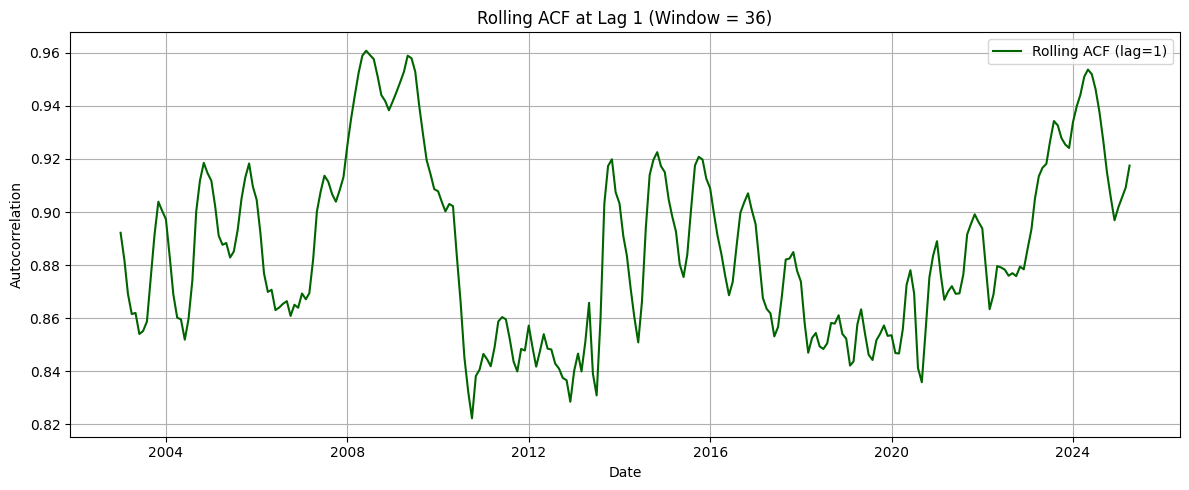

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


series = original_data['SPCS20RPSNSA']

# Set rolling window size
window_size = 36  # 3 years, assuming monthly data

# Compute rolling autocorrelation at lag 1
rolling_acf_lag1 = []
for i in range(window_size, len(series)):
    window = series[i - window_size:i]
    if window.isnull().any():
        rolling_acf_lag1.append(np.nan)
    else:
        acf_val = window.autocorr(lag=1)
        rolling_acf_lag1.append(acf_val)

# Create index and DataFrame
acf_index = series.index[window_size:]
rolling_acf_df = pd.DataFrame({
    'date': acf_index,
    'rolling_acf_lag1': rolling_acf_lag1
}).set_index('date')

# Plot the rolling ACF at lag 1
plt.figure(figsize=(12, 5))
plt.plot(rolling_acf_df.index, rolling_acf_df['rolling_acf_lag1'], color='darkgreen', label='Rolling ACF (lag=1)')
plt.title('Rolling ACF at Lag 1 (Window = 36)')
plt.xlabel('Date')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Rolling ACF Shows:
How autocorrelation (lag relationships) change over time

Whether the dependence structure is stable

If the series violates the assumption of stationarity

🔍 What You Learn from It:
Pattern in Rolling ACF	What It Means
ACF stays roughly constant over time	✅ Likely stationary autocorrelation structure
ACF trends upward/downward or fluctuates wildly	❌ Non-stationary — time series structure is changing
Spikes during certain periods	🔄 Possible regime shifts, seasonality, or structural breaks.

###################################################################################################################

What the Rolling ACF Plot Shows:
Fluctuations in autocorrelation over time (ranging roughly from ~0.82 to ~0.96).

Noticeable dips and peaks, especially:

Around 2008–2011, there's a sudden drop and then relatively low/stable ACF.

After 2020, ACF starts rising again.

🧠 Conclusion: The Autocorrelation Structure Is Not Constant
This violates the third assumption of weak stationarity.

Evidence	Interpretation
ACF at lag 1 changes significantly over time	➤ The time series has time-varying autocorrelation, i.e., non-stationary structure.
Long periods of rising or falling ACF	➤ Possibly reflects regime shifts, policy changes, or external shocks (e.g., 2008 crash, 2020 pandemic)

##############################################################################################################################

hy Do We Use ACF at Lag 1?
✅ 1. Lag 1 is the most immediate memory of a time series
It tells you how strongly today’s value is related to yesterday’s (or previous time step).

If this correlation is strong and stable, it often means the series has short-term dependence, which many models (like AR, ARIMA) exploit.

✅ 2. First place to check for non-stationarity
In a non-stationary series, the ACF at lag 1 is typically very high (close to 1), and doesn't decay quickly.

Watching how ACF at lag 1 changes over time helps you detect time-varying dependence — i.e., when the time series structure is changing.

✅ 3. Fast, interpretable diagnostic
Rolling ACF at lag 1 is:

Easy to compute

Fast to visualize

Easy to interpret: high values mean strong correlation with the previous time step

🔬 What If You Want More?
You can compute rolling ACF at multiple lags (lag 2, lag 12, etc.) depending on your use case.

For example:

Lag 12 might be useful if your data is monthly and you suspect seasonality.

A full ACF plot over a rolling window (not just one lag) can reveal deeper structures.

##################################################################################################

Why Use a 36-Month (3-Year) Rolling Window?
✅ 1. Balance Between Stability and Sensitivity
A rolling window needs to be long enough to compute reliable statistics (like autocorrelation).

But it shouldn't be so long that it hides structural changes.

36 months (3 years) is often a good middle ground:

Long enough to get meaningful autocorrelation

Short enough to detect medium-term changes in structure

✅ 2. Seasonality Consideration (Monthly Data)
Your data is monthly, and housing or economic time series often show yearly patterns.

So:

12 months = 1 cycle

36 months = 3 full seasonal cycles
This makes the window better at smoothing out noise and capturing underlying trends or shifts.

✅ 3. Standard Practice in Economics and Finance
In housing, macroeconomic, or financial time series, rolling statistics over 36 months are commonly used to:

Analyze economic cycles

Track medium-term trends

Smooth out temporary fluctuations


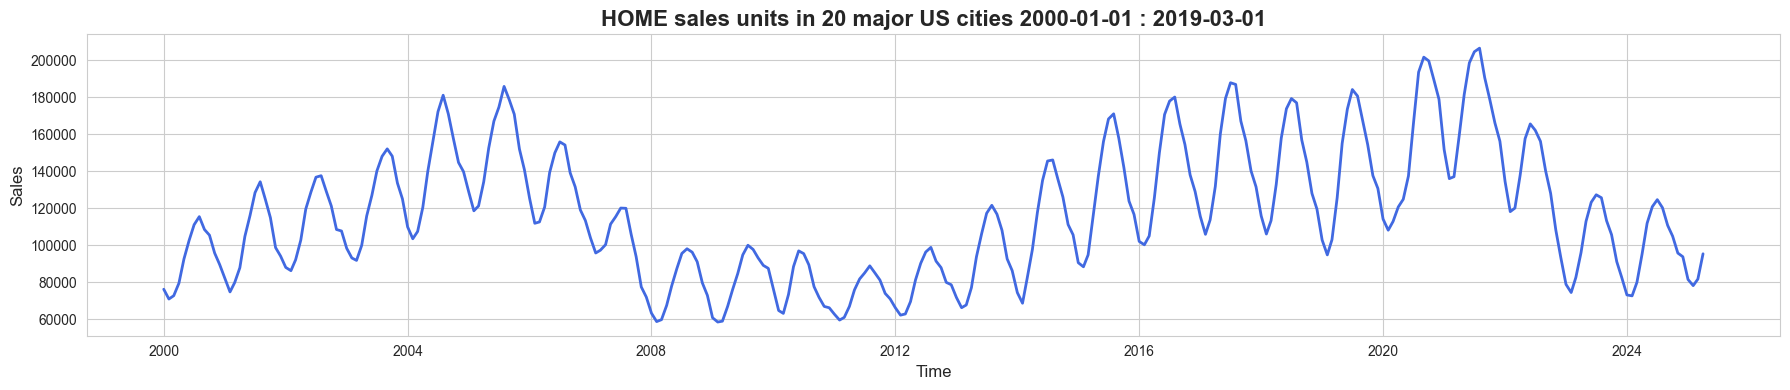

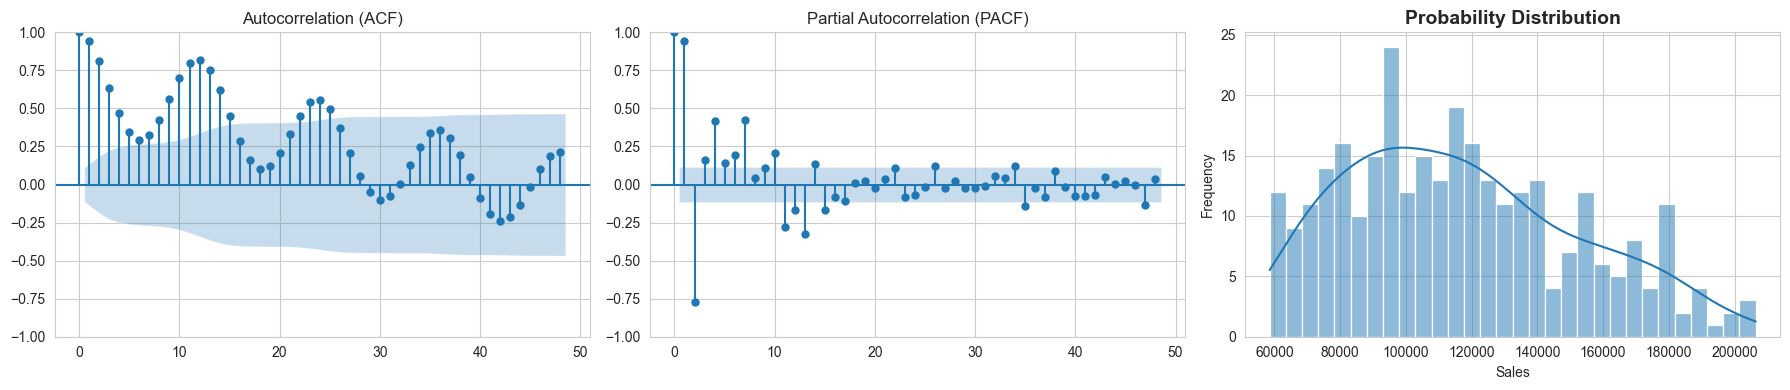

In [18]:
plot_data_properties(original_data, 'HOME sales units in 20 major US cities 2000-01-01 : 2019-03-01');

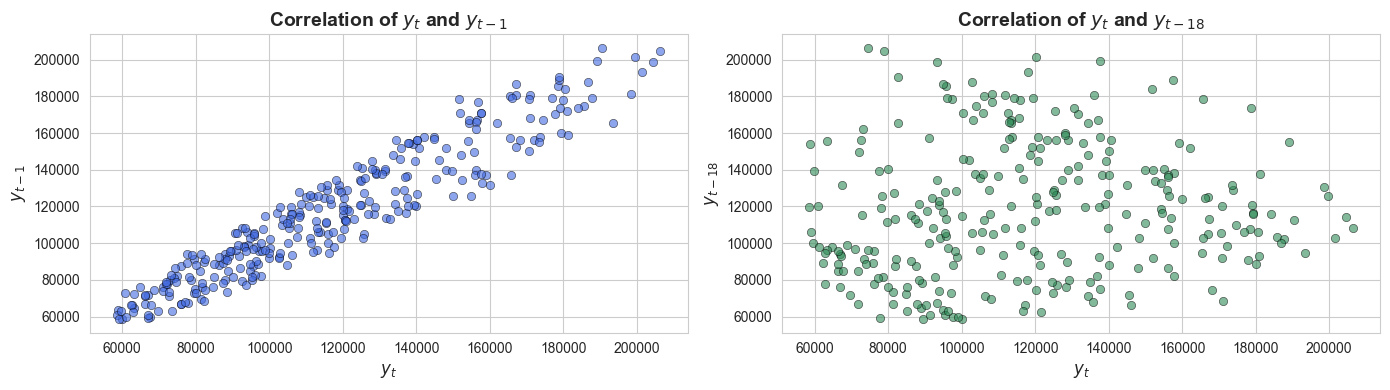

In [19]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 4), squeeze=False)

axes[0, 0].scatter(
    x=original_data[1:], 
    y=original_data.shift(1)[1:], 
    alpha=0.6, 
    edgecolor='black', 
    linewidth=0.5, 
    color='royalblue'
)
    
axes[0, 0].set_title('Correlation of $y_t$ and $y_{t-1}$', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('$y_t$', fontsize=12)
axes[0, 0].set_ylabel('$y_{t-1}$', fontsize=12)
axes[0, 0].grid(True)

axes[0, 1].scatter(
    x=original_data[18:], 
    y=original_data.shift(18)[18:], 
    alpha=0.6, 
    edgecolor='black', 
    linewidth=0.5, 
    color='seagreen'
)

axes[0, 1].set_title('Correlation of $y_t$ and $y_{t-18}$', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('$y_t$', fontsize=12)
axes[0, 1].set_ylabel('$y_{t-18}$', fontsize=12)
axes[0, 1].grid(True)

plt.tight_layout()
plt.show()

 Interpretation:
🔹 Left Plot (Lag 1 Correlation):
Strong positive linear correlation — points tightly clustered around a diagonal line.

This shows strong short-term dependence — each value is highly dependent on the previous one.

It’s also a signal of non-stationarity, since such strong correlation is typical in trending or non-stationary series.

🔹 Right Plot (Lag 18 Correlation):
Scattered points with no clear pattern.

This suggests that lag 18 has little to no predictive power for yₜ.

It also implies no seasonal pattern at a lag of 18 months — often tested in monthly time series for seasonality (~12, 24, etc.).

📌 What You Can Conclude:
Observation	Conclusion
Strong correlation at lag 1	➤ Likely non-stationary; strong autocorrelation
Weak/no correlation at lag 18	➤ No seasonality at 18 months, and short memory process

In [20]:
from statsmodels.tsa.seasonal import STL
import pandas as pd

def detect_seasonality(series, period):
    stl = STL(series, period=period, robust=True)
    result = stl.fit()

    seasonal_strength = 1 - (np.var(result.resid) / np.var(result.resid + result.seasonal))

    return {
        "Seasonal Strength": seasonal_strength,
        "Is Seasonal": seasonal_strength > 0.64  # rule-of-thumb threshold
    }
detect_seasonality(original_data['SPCS20RPSNSA'],12)

{'Seasonal Strength': np.float64(0.8847045853668963), 'Is Seasonal': np.True_}

In [21]:
from statsmodels.tsa.stattools import acf

def acf_seasonality_test(series, period, threshold=0.5):
    acf_vals = acf(series, nlags=period * 2)
    return {
        "ACF at lag {}".format(period): acf_vals[period],
        "Is Seasonal": abs(acf_vals[period]) > threshold
    }
acf_seasonality_test(original_data['SPCS20RPSNSA'],12)

{'ACF at lag 12': np.float64(0.8202780235498544), 'Is Seasonal': np.True_}

In [22]:
def check_seasonality_auto(series, period):
    stl_result = detect_seasonality(series, period)
    acf_result = acf_seasonality_test(series, period)
    if stl_result["Is Seasonal"] and acf_result["Is Seasonal"]:
        final = True
        confidence = "High"
    elif stl_result["Is Seasonal"] or acf_result["Is Seasonal"]:
        final = True
        confidence = "Moderate"
    else:
        final = False
        confidence = "Low"


    return {
    "STL Strength": stl_result["Seasonal Strength"],
    "ACF Score": acf_result["ACF at lag {}".format(period)],
    "STL Verdict": stl_result["Is Seasonal"],
    "ACF Verdict": acf_result["Is Seasonal"],
    "Final Verdict": final,
    "Confidence Level": confidence
}

series = original_data['SPCS20RPSNSA']
log_series = np.log(series)

seasonality = check_seasonality_auto(log_series, period=12)  # 12 = monthly → yearly
for k, v in seasonality.items():
    print(f"{k}: {v}")


STL Strength: 0.8851339747189051
ACF Score: 0.8316985379641456
STL Verdict: True
ACF Verdict: True
Final Verdict: True
Confidence Level: High


In [23]:
def test_stationarity(data, column='SPCS20RPSNSA'):
    
    if isinstance(data, pd.DataFrame):
        series = data[column].dropna()
    else:
        series = pd.Series(data).dropna()
        
    adf_stat, adf_pval, _, _, _, _ = adfuller(series)
    print("=== Augmented Dickey-Fuller Test (ADF) ===")
    print(f"ADF Statistic : {adf_stat:.4f}")
    print(f"p-value       : {adf_pval:.4f}")
    if adf_pval >= 0.05:
        print("→ Fail to reject H₀: Series is NOT stationary")
    else:
        print("→ Reject H₀: Series is STATIONARY")
    print()

    kpss_stat, kpss_pval, _, _ = kpss(series, regression='c', nlags="auto")
    print("=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===")
    print(f"KPSS Statistic : {kpss_stat:.4f}")
    print(f"p-value        : {kpss_pval:.4f}")
    if kpss_pval <= 0.05:
        print("→ Reject H₀: Series is NOT stationary")
    else:
        print("→ Fail to reject H₀: Series is STATIONARY")

In [24]:
test_stationarity(original_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.7994
p-value       : 0.0584
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.4891
p-value        : 0.0441
→ Reject H₀: Series is NOT stationary


Adf and kpss test basically checks for weak stationarity only and its enough for models like ARIMA,SARIMA.. Strict stationarity is not actually observed much in real data, we can see that only by KS test by comparing distributions

In [25]:
original_data2 = original_data.copy()
original_data2

,SPCS20RPSNSA
observation_date,
2000-01-01,76273
2000-02-01,70994
2000-03-01,72795
2000-04-01,79561
2000-05-01,92584
...,...
2024-12-01,93822
2025-01-01,81549
2025-02-01,78228


KS Statistic: 0.3092
P-value: 0.0000
❌ Reject H0: The distributions are different (not strictly stationary)


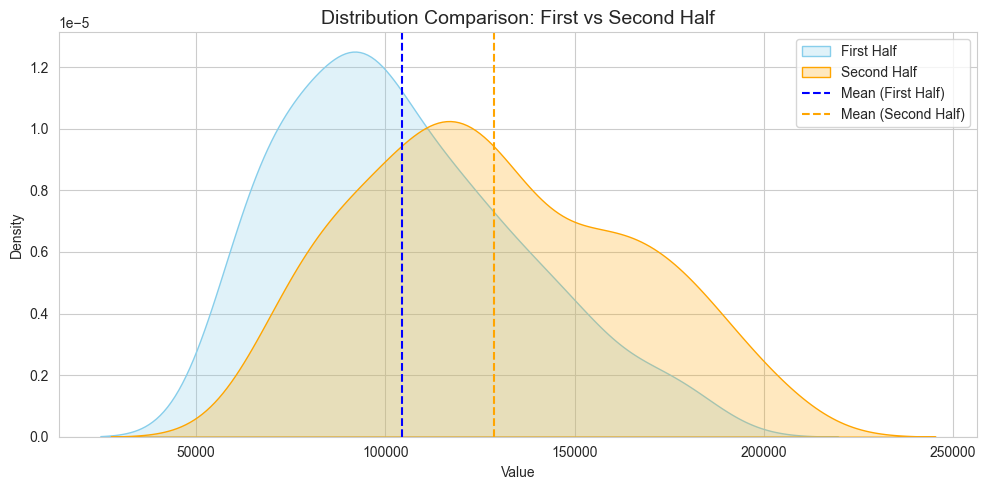

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# 🔸 Clean and flatten the data
originial_data2 = original_data.copy()
original_data2 = original_data2.values.ravel()
mid = len(original_data2) // 2

# Split the series
ts1 = original_data2[:mid]
ts2 = original_data2[mid:]

# Perform KS test
ks_stat, p_value = ks_2samp(ts1, ts2)

# Print result
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("❌ Reject H0: The distributions are different (not strictly stationary)")
else:
    print("✅ Fail to reject H0: No evidence distributions differ (possibly strictly stationary)")

# 🔹 Plot the distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(ts1, label='First Half', fill=True, color='skyblue')
sns.kdeplot(ts2, label='Second Half', fill=True, color='orange')

plt.title('Distribution Comparison: First vs Second Half', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Density')
plt.axvline(np.mean(ts1), color='blue', linestyle='--', label='Mean (First Half)')
plt.axvline(np.mean(ts2), color='orange', linestyle='--', label='Mean (Second Half)')
plt.legend()
plt.tight_layout()
plt.show()


Strict Stationarity (Strong Stationarity)
A time series is strictly stationary if its entire distribution does not change over time.

✔️ That means:
The mean, variance, skewness, kurtosis, etc. — all statistical properties are constant over time.

For any time points 
𝑡
1
,
𝑡
2
,
.
.
.
,
𝑡
𝑘
t 
1
​
 ,t 
2
​
 ,...,t 
k
​
 , the joint distribution of 
(
𝑋
𝑡
1
,
𝑋
𝑡
2
,
.
.
.
,
𝑋
𝑡
𝑘
)
(X 
t 
1
​
 
​
 ,X 
t 
2
​
 
​
 ,...,X 
t 
k
​
 
​
 ) is the same as 
(
𝑋
𝑡
1
+
ℎ
,
𝑋
𝑡
2
+
ℎ
,
.
.
.
,
𝑋
𝑡
𝑘
+
ℎ
)
(X 
t 
1
​
 +h
​
 ,X 
t 
2
​
 +h
​
 ,...,X 
t 
k
​
 +h
​
 ), for all 
ℎ
h.

✅ Very strict condition — rarely satisfied in real-world data.

2. Weak Stationarity (Second-order Stationarity)
A time series is weakly stationary if:

Mean is constant over time.

Variance is constant over time.

Covariance between two time points depends only on the lag (difference), not on actual time

This is the assumption used in most time series models (like ARIMA, SARIMA).

In [27]:
# Define the split date
test_start_date = '2022-12-01'

# Now slicing works correctly
training_data = original_data[:test_start_date]
test_data = original_data[test_start_date:]

training_series = training_data['SPCS20RPSNSA']
test_series = test_data['SPCS20RPSNSA']


In [28]:
def plot_seasonal_decompose(data, model='multiplicative'):
    
    sns.set_style("whitegrid")

    decomposition = seasonal_decompose(data, model=model)

    fig, axes = plt.subplots(4, 1, figsize=(20, 14), sharex=True, gridspec_kw={'hspace': 0.5})

    # Original series
    axes[0].plot(data, color='royalblue', linewidth=1.5, alpha=0.9)
    axes[0].set_title('Original Time Series', fontsize=20)
    axes[0].grid(True)

    # Trend
    axes[1].plot(decomposition.trend, color='darkorange', linewidth=1.5)
    axes[1].set_title('Trend Component', fontsize=20)
    axes[1].grid(True)

    # Seasonality
    axes[2].plot(decomposition.seasonal, color='mediumseagreen', linewidth=1.5)
    axes[2].set_title('Seasonal Component', fontsize=20)
    axes[2].grid(True)

    # Residuals
    axes[3].plot(decomposition.resid, color='gray', linewidth=1.5)
    axes[3].set_title('Residual Component', fontsize=20)
    axes[3].grid(True)

    # Common tick and label sizes
    for ax in axes:
        ax.tick_params(axis='both', labelsize=14)

    plt.suptitle('Seasonal Decomposition of Time Series', fontsize=26, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

    return decomposition

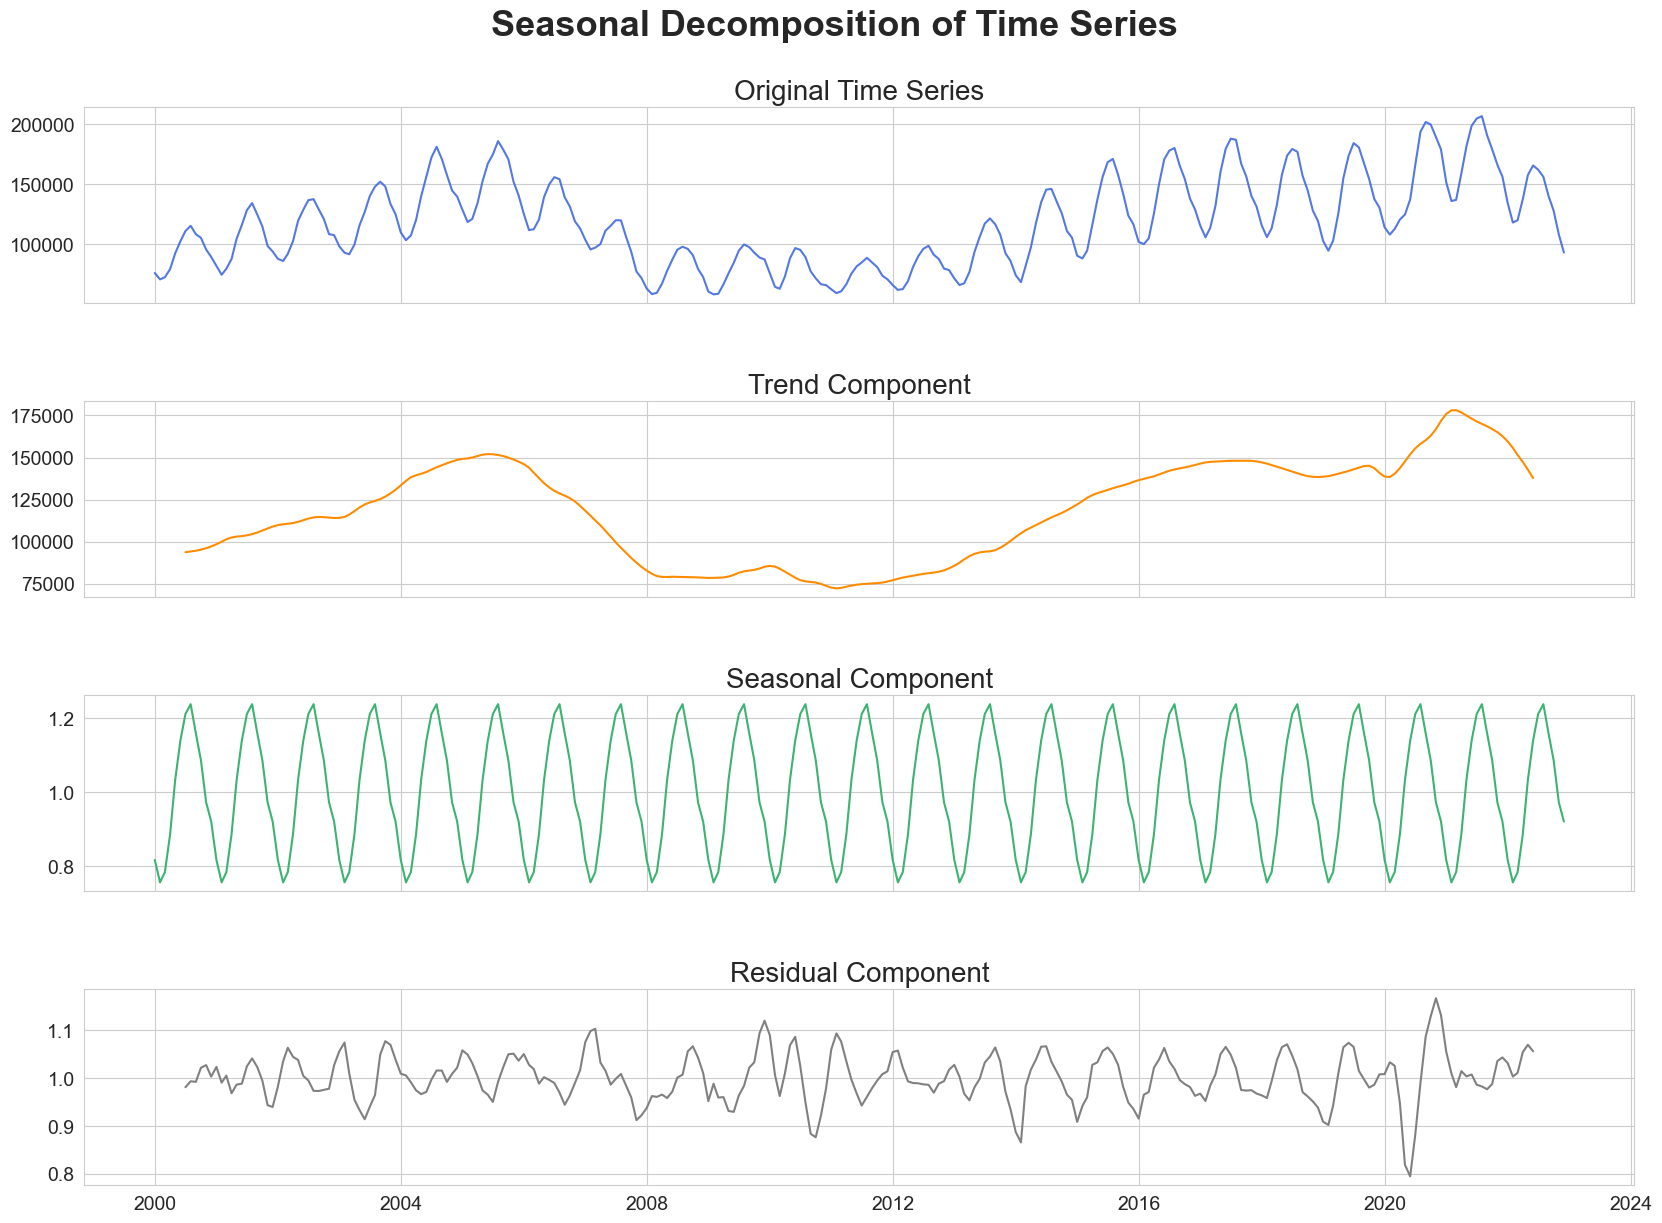

In [29]:
decomposition = plot_seasonal_decompose(training_series, model='multiplicative')

Breakdown of Components
✅ Original Time Series
Clear upward and downward trend over the years.

Seasonal oscillations (peaks and troughs) vary in height over time.

✅ Trend Component
Smooth long-term movement in the data (increasing and decreasing sections).

Supports the presence of a strong trend.

✅ Seasonal Component
The seasonal pattern stays regular in shape, but look at the scale:

Seasonal values fluctuate between ~0.8 and ~1.2, not centered around 0.

This indicates multiplicative seasonality, because:

In additive models, seasonal values typically center around 0.

In multiplicative models, they center around 1.

✅ Residual Component
Fluctuations around 1.0 rather than 0.

Again, this supports multiplicative decomposition.

If it were additive, residuals would be centered around 0.

✅ Final Conclusion
Your time series definitely follows a multiplicative structure.

## Checking for Cyclic behavious

In your decomposition:

After removing trend and seasonality, if the residuals show long-term wave-like patterns, those may be cyclic components.

However, if residuals look mostly random (which yours do), cyclic behavior is weak or not present.

In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.signal import periodogram

def detect_cycles(series, freq='M'):
    """
    Detect cyclic behavior in a time series.

    Parameters:
        series (pd.Series): The time series data with a datetime index.
        freq (str): Frequency of the data (e.g., 'M' for monthly, 'Q' for quarterly)

    Returns:
        dict: Summary of cycle indicators.
    """
    # HP filter decomposition
    cycle, trend = hpfilter(series, lamb=1600 if freq == 'M' else 129600 if freq == 'Q' else 100)
    
    # Spectral density analysis
    freqs, power = periodogram(series.dropna(), scaling='spectrum')
    top_freqs = freqs[np.argsort(power)[-3:]]  # top 3 frequencies with highest power

    return {
        "Cycle Std Dev (HP Filter)": np.std(cycle),
        "Top Frequencies": top_freqs.tolist(),
        "Has Cyclic Component": np.std(cycle) > 0.05  # adjustable threshold
    }
result = detect_cycles(original_data['SPCS20RPSNSA'], freq='M')
print(result)

{'Cycle Std Dev (HP Filter)': np.float64(20559.25627136391), 'Top Frequencies': [0.08223684210526315, 0.003289473684210526, 0.006578947368421052], 'Has Cyclic Component': np.True_}


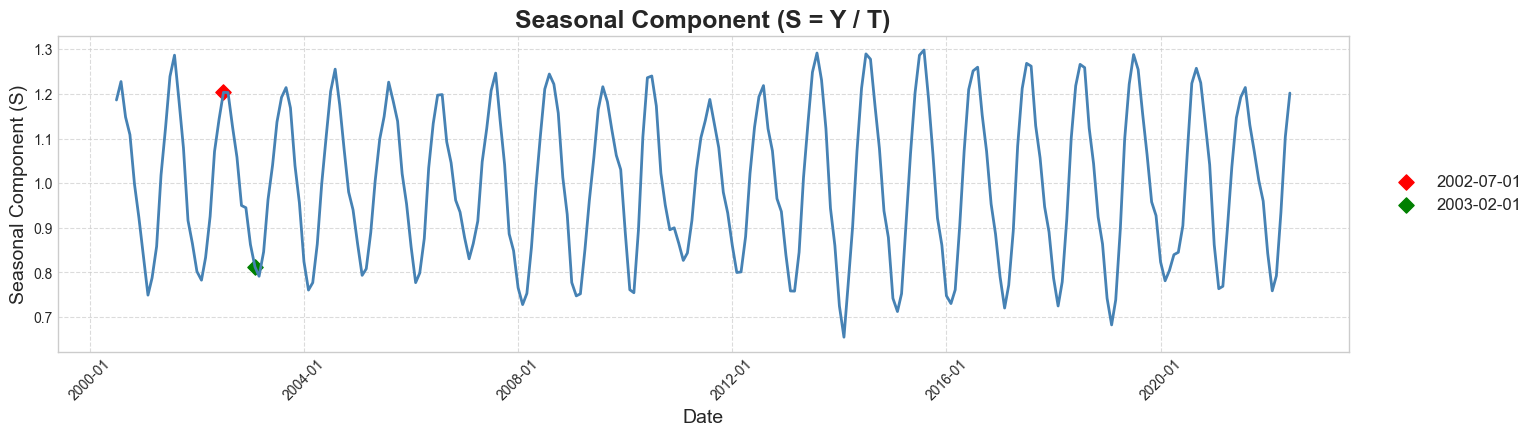

In [31]:
seasonal_component = training_series / decomposition.trend

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(seasonal_component, color='steelblue', linewidth=2)

ax.scatter(pd.to_datetime('2002-07-01'), seasonal_component.loc['2002-07-01'],
           marker='D', s=60, color='red', label='2002-07-01')
ax.scatter(pd.to_datetime('2003-02-01'), seasonal_component.loc['2003-02-01'],
           marker='D', s=60, color='green', label='2003-02-01')

ax.set_title('Seasonal Component (S = Y / T)', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seasonal Component (S)', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)

plt.tight_layout(pad=3)
plt.show()

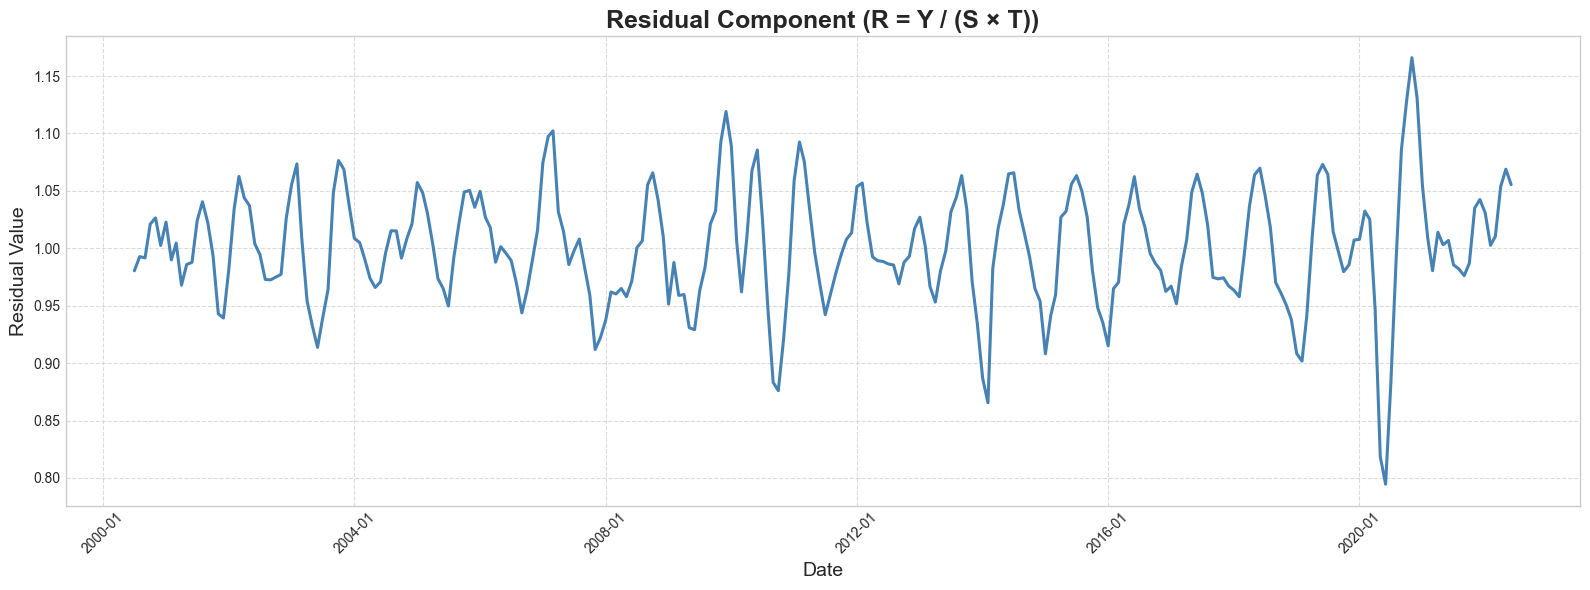

In [32]:
residual_component = training_series / (decomposition.trend * decomposition.seasonal)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(residual_component, color='steelblue', linewidth=2.2)

ax.set_title('Residual Component (R = Y / (S × T))', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Residual Value', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

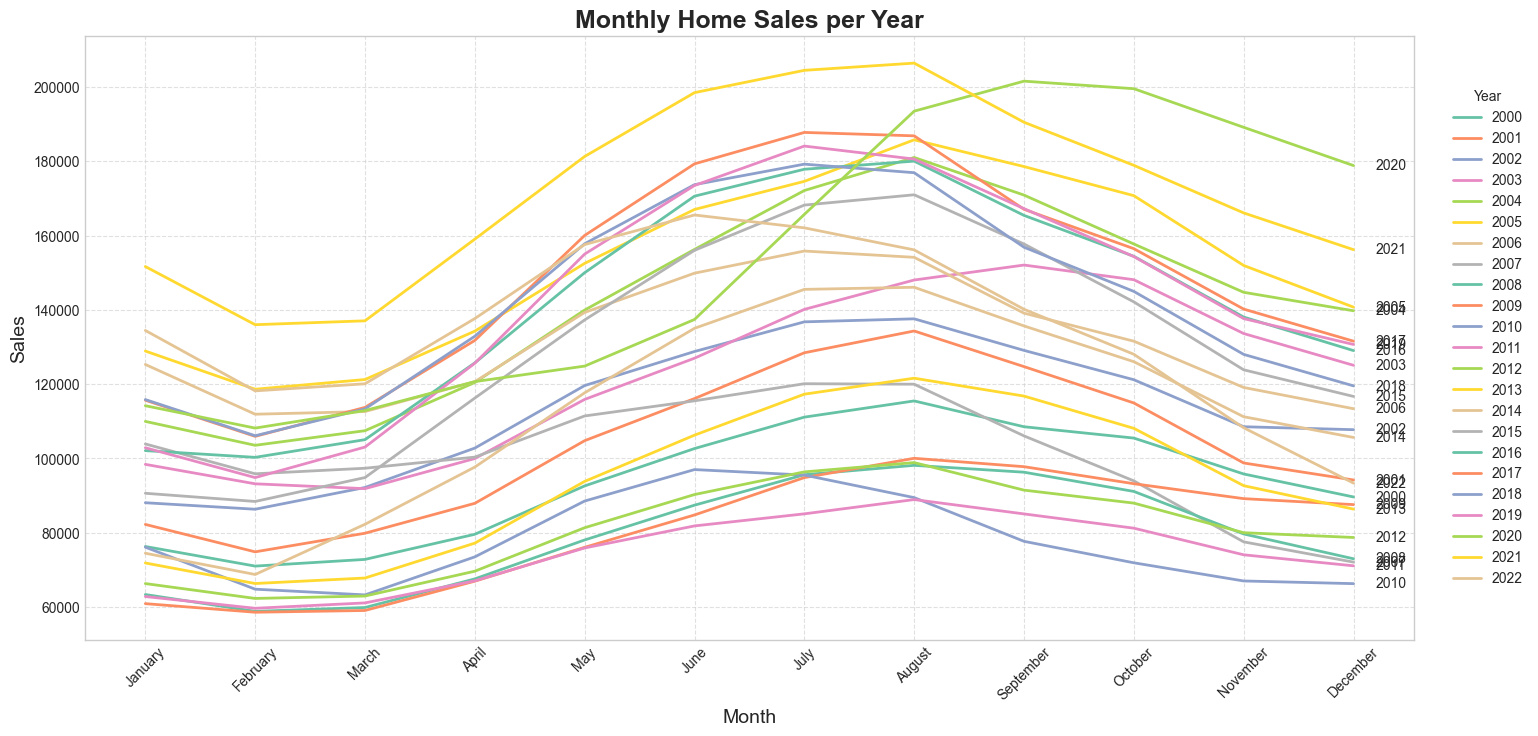

In [33]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

fig, ax = plt.subplots(figsize=(16, 8))
ax.grid(True, which='both', linestyle='--', alpha=0.6)

years = int(np.round(len(training_data) / 12))
months = training_data.index[:12].month_name()

for i in range(years):
    index = training_data.index[i * 12:(i + 1) * 12]
    monthly_values = training_data.loc[index].values
    
    ax.plot(months, monthly_values, linewidth=2)
    ax.text(x=11.2, y=monthly_values[-1], s=str(training_data.index.year.unique()[i]),
            fontsize=10, verticalalignment='center')

ax.set_title('Monthly Home Sales per Year', fontsize=18, fontweight='bold')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

plt.xticks(rotation=45)
ax.legend(training_data.index.year.unique(), title='Year', bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=10)

plt.tight_layout(pad=3)
plt.show()

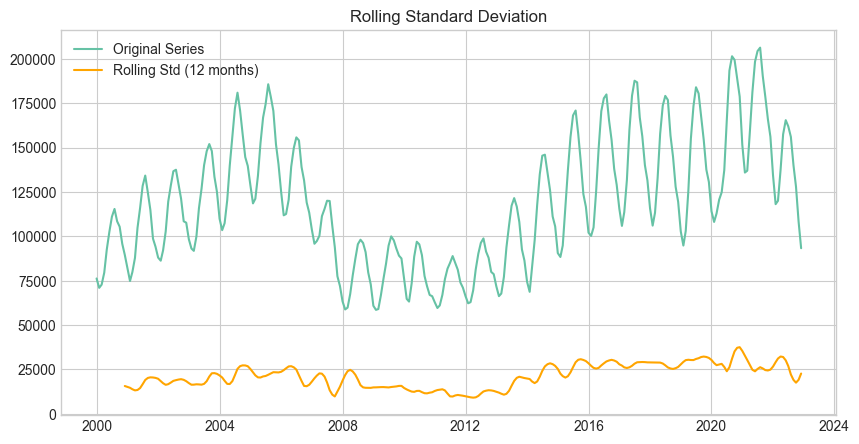

In [34]:
rolling_std = training_data.rolling(window=12).std()

plt.figure(figsize=(10, 5))
plt.plot(training_series, label='Original Series')
plt.plot(rolling_std, label='Rolling Std (12 months)', color='orange')
plt.legend()
plt.title("Rolling Standard Deviation")
plt.show()


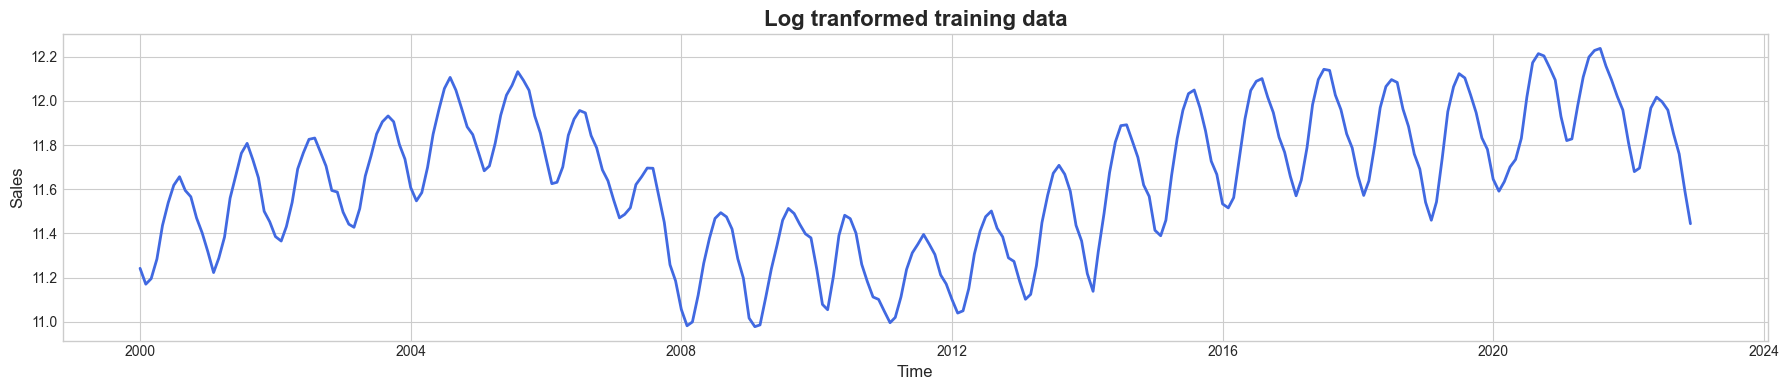

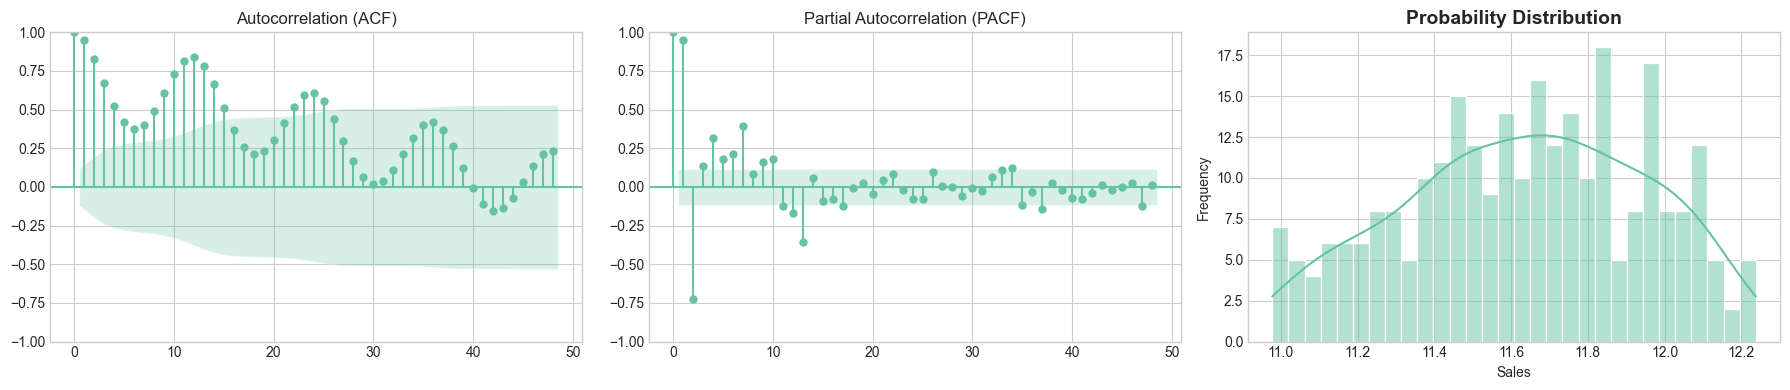

In [35]:
log_transformed_data = np.log(training_data)
plot_data_properties(log_transformed_data, 'Log tranformed training data')

In [36]:
log_transformed_data

,SPCS20RPSNSA
observation_date,
2000-01-01,11.242074
2000-02-01,11.170351
2000-03-01,11.195403
2000-04-01,11.284279
2000-05-01,11.435872
...,...
2022-08-01,11.958463
2022-09-01,11.850469
2022-10-01,11.759989


In [37]:
test_stationarity(log_transformed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.5548
p-value       : 0.1027
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.7105
p-value        : 0.0126
→ Reject H₀: Series is NOT stationary


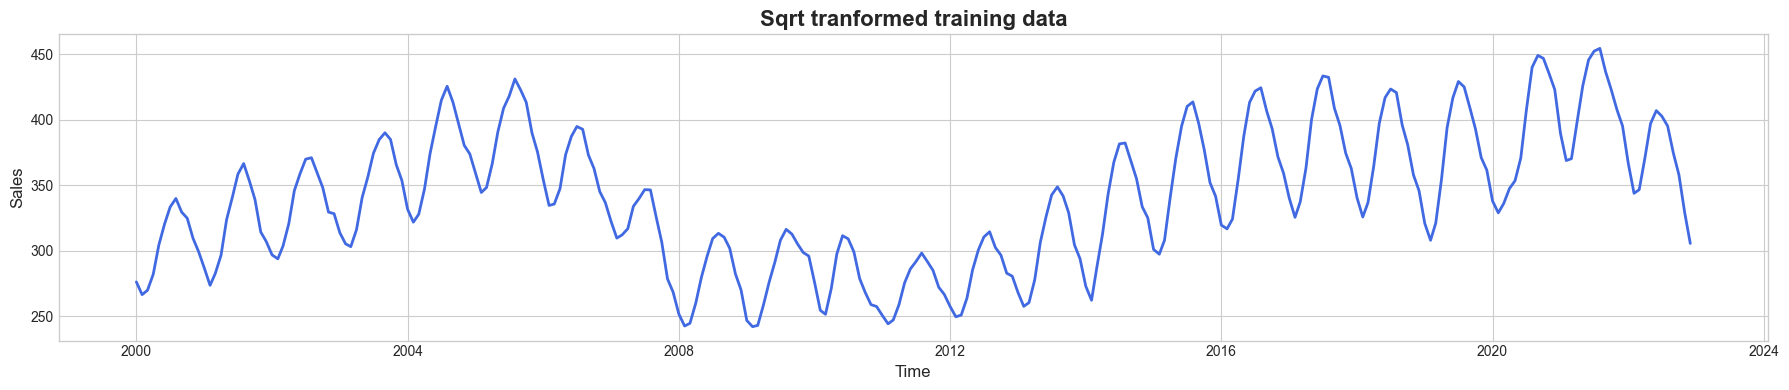

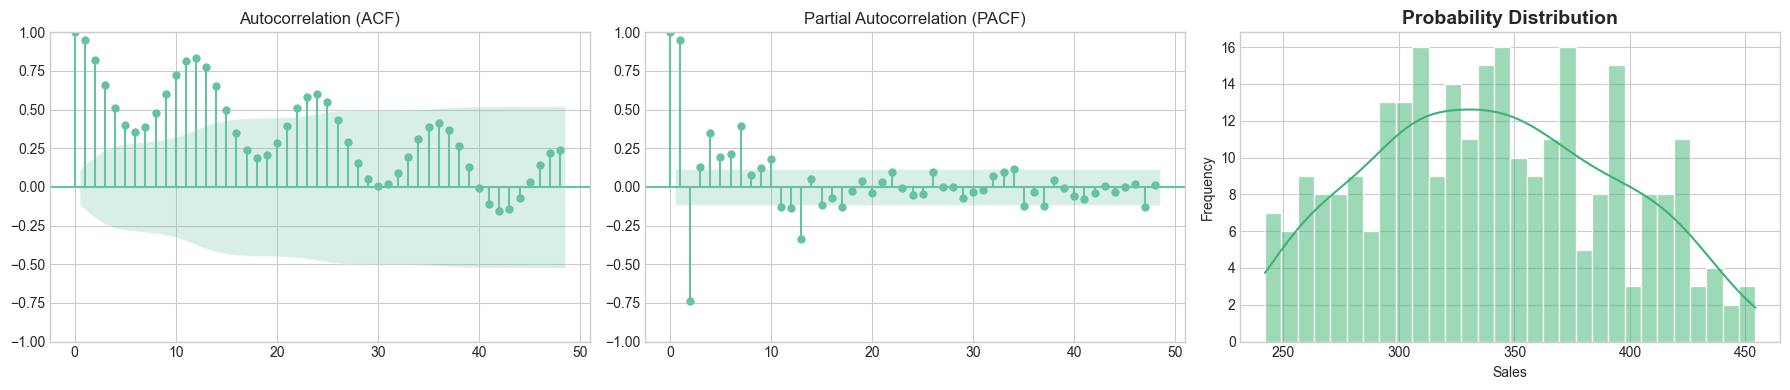

In [38]:
# lets try sqrt transformation 
# Square root transformation
train_sqrt = np.sqrt(training_series)
plot_data_properties(train_sqrt, 'Sqrt tranformed training data')

In [39]:
test_stationarity(log_transformed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -2.5548
p-value       : 0.1027
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.7105
p-value        : 0.0126
→ Reject H₀: Series is NOT stationary


Box-Cox Lambda: 0.2619


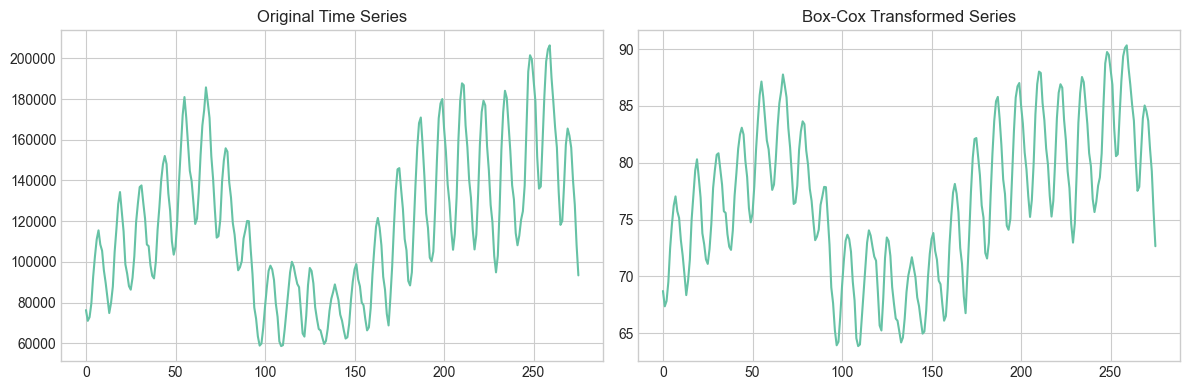


ADF Statistic: -2.6375
p-value: 0.0855
❌ Still non-stationary (fail to reject H0). Consider differencing next.


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

# Ensure positive and convert to array
training_data = training_data[training_data > 0].values.ravel()

# Apply Box-Cox
ts_boxcox, fitted_lambda = boxcox(training_data)

print(f"Box-Cox Lambda: {fitted_lambda:.4f}")

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_data)
plt.title("Original Time Series")

plt.subplot(1, 2, 2)
plt.plot(ts_boxcox)
plt.title("Box-Cox Transformed Series")

plt.tight_layout()
plt.show()

# ADF Test
result = adfuller(ts_boxcox)
print(f"\nADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

if result[1] < 0.05:
    print("✅ Transformed series is stationary (reject H0).")
else:
    print("❌ Still non-stationary (fail to reject H0). Consider differencing next.")


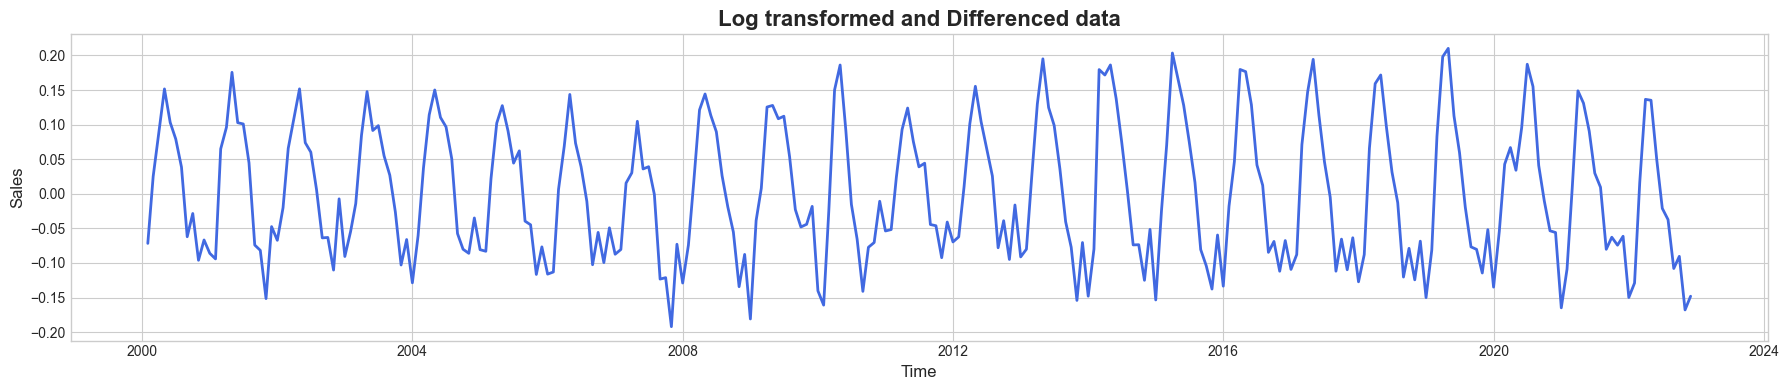

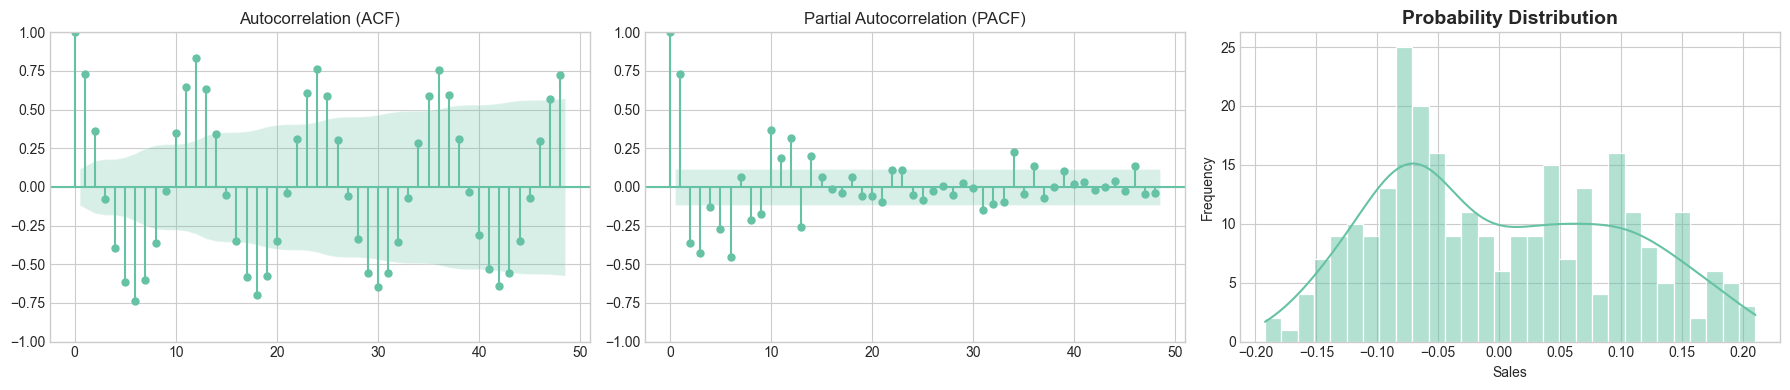

In [41]:
logged_diffed_data = log_transformed_data.diff()[1:]
plot_data_properties(logged_diffed_data, 'Log transformed and Differenced data')

In [42]:
logged_diffed_data

,SPCS20RPSNSA
observation_date,
2000-02-01,-0.071724
2000-03-01,0.025052
2000-04-01,0.088877
2000-05-01,0.151592
2000-06-01,0.103150
...,...
2022-08-01,-0.037332
2022-09-01,-0.107995
2022-10-01,-0.090480


In [43]:
test_stationarity(logged_diffed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -1.9401
p-value       : 0.3134
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.0377
p-value        : 0.1000
→ Fail to reject H₀: Series is STATIONARY


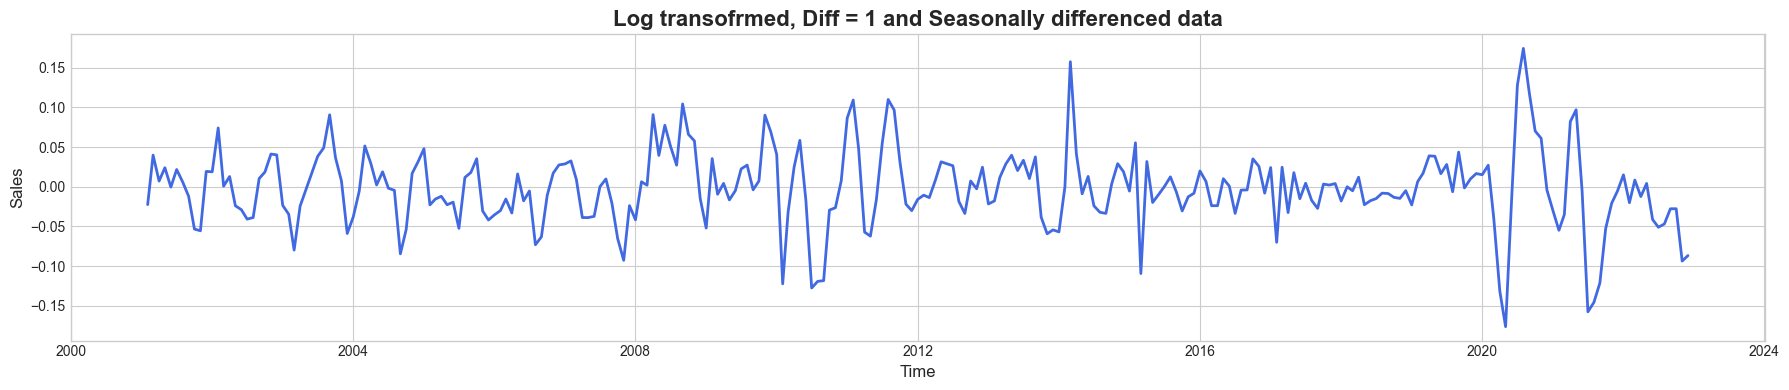

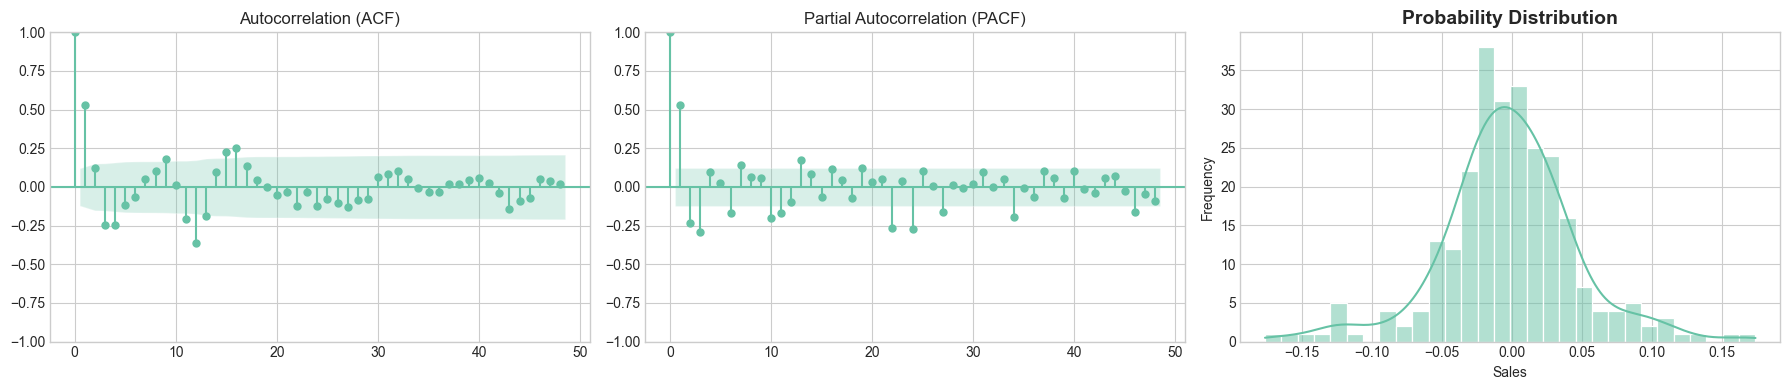

In [44]:
seasonally_diffed_data = logged_diffed_data.diff(12)[12:]
plot_data_properties(seasonally_diffed_data, 'Log transofrmed, Diff = 1 and Seasonally differenced data')

In [45]:
seasonally_diffed_data.head()

,SPCS20RPSNSA
observation_date,
2001-02-01,-0.022444
2001-03-01,0.039816
2001-04-01,0.007190
2001-05-01,0.023992
2001-06-01,-0.000394


In [46]:
test_stationarity(seasonally_diffed_data)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -3.2155
p-value       : 0.0191
→ Reject H₀: Series is STATIONARY

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.1799
p-value        : 0.1000
→ Fail to reject H₀: Series is STATIONARY


In [47]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(seasonally_diffed_data, lags=[10, 20, 30], return_df=True)

print(lb_test)

       lb_stat     lb_pvalue
10  129.408971  6.165714e-23
20  228.206445  2.734347e-37
30  253.079459  3.852233e-37


If you're testing your seasonal_diffed_data using Ljung-Box, then:

H₀ (null): Data is white noise (no autocorrelation → no pattern).

H₁ (alt): Data is autocorrelated (some structure → potentially modelable).

📌 So:
p-value > 0.05	Your differenced data is white noise → ❌ Not useful for ARIMA modeling
p-value ≤ 0.05	Your differenced data has autocorrelation → ✅ Can be modeled

In [48]:
def shapiro_normality_test(data):
    
    stat, p_value = shapiro(data)
    mean = np.round(np.mean(data), 3)
    std = np.round(np.std(data), 3)
    
    print(f"Shapiro-Wilk Test Statistic: {stat:.3f}")
    print(f"P-Value: {p_value:.3f}")
    
    if p_value >= 0.05:
        print(f"\033[92mData appears to be normally distributed (X ~ N({mean}, {std})).\033[0m")
    else:
        print(f"\033[91mData does NOT follow a normal distribution (p < 0.05).\033[0m")

shapiro_normality_test(seasonally_diffed_data.SPCS20RPSNSA)

Shapiro-Wilk Test Statistic: 0.964
P-Value: 0.000
Data does NOT follow a normal distribution (p < 0.05).


It is actually irrelevant to check for normality of the data incase of time series but i still did it so ignore

Behavior	ACF Pattern	PACF Pattern	Likely Conclusion 

Long decay in ACF	Slowly decaying	One strong spike, then fade	Non-stationary, trending

Short decay in ACF	Cuts off after few lags	Sharp cutoff	Stationary

Seasonal structure	Regular spikes at seasonal lag	Regular spikes at seasonal lag	Seasonal, may still be stationary after seasonal differencing

In [49]:
# so both detrending and moving avg cant make the data stationary so we move with

In [50]:
def best_sarima_model(train_data, p, q, P, Q, d=1, D=1, s=12):
    
    best_model_aic = np.inf
    best_model_bic = np.inf
    best_model_hqic = np.inf
    best_model_order = None
    best_model = None
    models = []

    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        model = SARIMAX(endog=train_data,
                                        order=(p_, d, q_),
                                        seasonal_order=(P_, D, Q_, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit(disp=False)
                        
                        models.append(model)

                        no_of_better_metrics = sum([
                            model.aic <= best_model_aic,
                            model.bic <= best_model_bic,
                            model.hqic <= best_model_hqic
                        ])

                        if no_of_better_metrics >= 2:
                            best_model = model
                            best_model_aic = np.round(model.aic, 2)
                            best_model_bic = np.round(model.bic, 2)
                            best_model_hqic = np.round(model.hqic, 2)
                            best_model_order = (p_, d, q_, P_, D, Q_, s)

                            print(f"Best so far: SARIMA{best_model_order} | "
                                  f"AIC={best_model_aic}, BIC={best_model_bic}, HQIC={best_model_hqic}, "
                                  f"Residual Mean={np.round(np.mean(np.abs(model.resid)), 4)}")

                    except Exception as e:
                        print(f"Failed for SARIMA({p_},{d},{q_})x({P_},{D},{Q_},{s}) → {e}")

    print("\nFinal Best SARIMA Model:")
    print(best_model.summary())

    return best_model, models

In [51]:
best_model, models = best_sarima_model(train_data=log_transformed_data, p=range(3), q=range(3), P=range(3), Q=range(3))

Best so far: SARIMA(0, 1, 0, 0, 1, 0, 12) | AIC=-838.87, BIC=-835.3, HQIC=-837.43, Residual Mean=0.1045
Best so far: SARIMA(0, 1, 0, 0, 1, 1, 12) | AIC=-898.45, BIC=-891.4, HQIC=-895.61, Residual Mean=0.0988
Best so far: SARIMA(0, 1, 1, 0, 1, 0, 12) | AIC=-910.81, BIC=-903.69, HQIC=-907.95, Residual Mean=0.1007
Best so far: SARIMA(0, 1, 1, 0, 1, 1, 12) | AIC=-962.8, BIC=-952.24, HQIC=-958.55, Residual Mean=0.0957
Best so far: SARIMA(0, 1, 2, 0, 1, 1, 12) | AIC=-1010.11, BIC=-996.06, HQIC=-1004.45, Residual Mean=0.0928

Final Best SARIMA Model:
                                      SARIMAX Results                                       
Dep. Variable:                         SPCS20RPSNSA   No. Observations:                  276
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 509.055
Date:                              Sun, 10 Aug 2025   AIC                          -1010.110
Time:                                      15:48:08   BIC                     

ARIMA (AutoRegressive Integrated Moving Average)
✅ ARIMA Assumptions:
Assumption	Description
1. Stationarity	The time series should be stationary (constant mean, variance, autocorrelation). Differencing (the "I" in ARIMA) is used to achieve this.
2. Linearity	The relationship between current values and past values/errors is linear.
3. No autocorrelation in residuals	After fitting, residuals should be white noise — no structure left.
4. Errors are uncorrelated and have constant variance (homoscedasticity)	Residuals should have constant spread (no clustering or volatility patterns).
5. Residuals are normally distributed (optional but helpful)	Not required for forecasting, but helps with confidence intervals and hypothesis testing.

📘 SARIMA (Seasonal ARIMA)
SARIMA extends ARIMA by adding seasonal terms — useful when your data has strong seasonal patterns (e.g., yearly, monthly, quarterly).

✅ SARIMA Assumptions = ARIMA Assumptions + Seasonal Stationarity
Additional Assumption	Description

6. Seasonal Stationarity	Seasonal patterns (e.g., yearly) must be stable across time. You can achieve this with seasonal differencing.

7. Correct seasonal period	You must specify the correct seasonal period (e.g., 12 for monthly data with yearly seasonality).

8. No seasonal autocorrelation in residuals	Just like non-seasonal ARIMA, SARIMA expects white noise residuals, including no seasonal lag spikes in ACF/PACF of residuals.

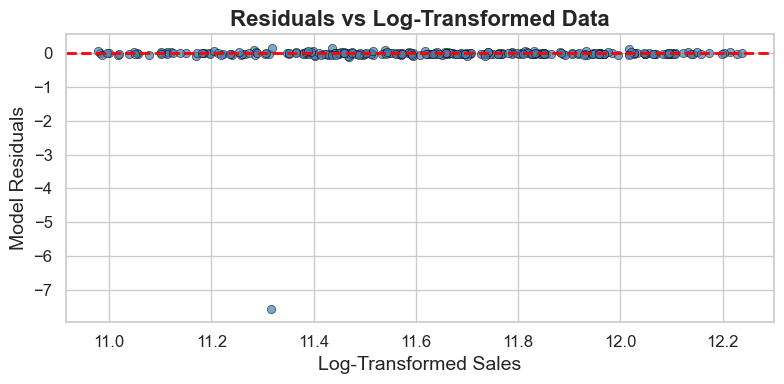

In [36]:
x_vals = log_transformed_data[1:].values.ravel()
y_vals = best_model.resid[1:].values.ravel()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.scatterplot(x=x_vals, y=y_vals, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs Log-Transformed Data', fontsize=16, fontweight='bold')
plt.xlabel('Log-Transformed Sales', fontsize=14)
plt.ylabel('Model Residuals', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We are checking for linearity between current value and past values
✅ Interpretation: 
What You See	What It Means
Random cloud around 0	✅ Linearity assumption holds
Curved, funnel, or pattern	❌ Possible non-linearity or heteroscedasticity

So the linearity holds

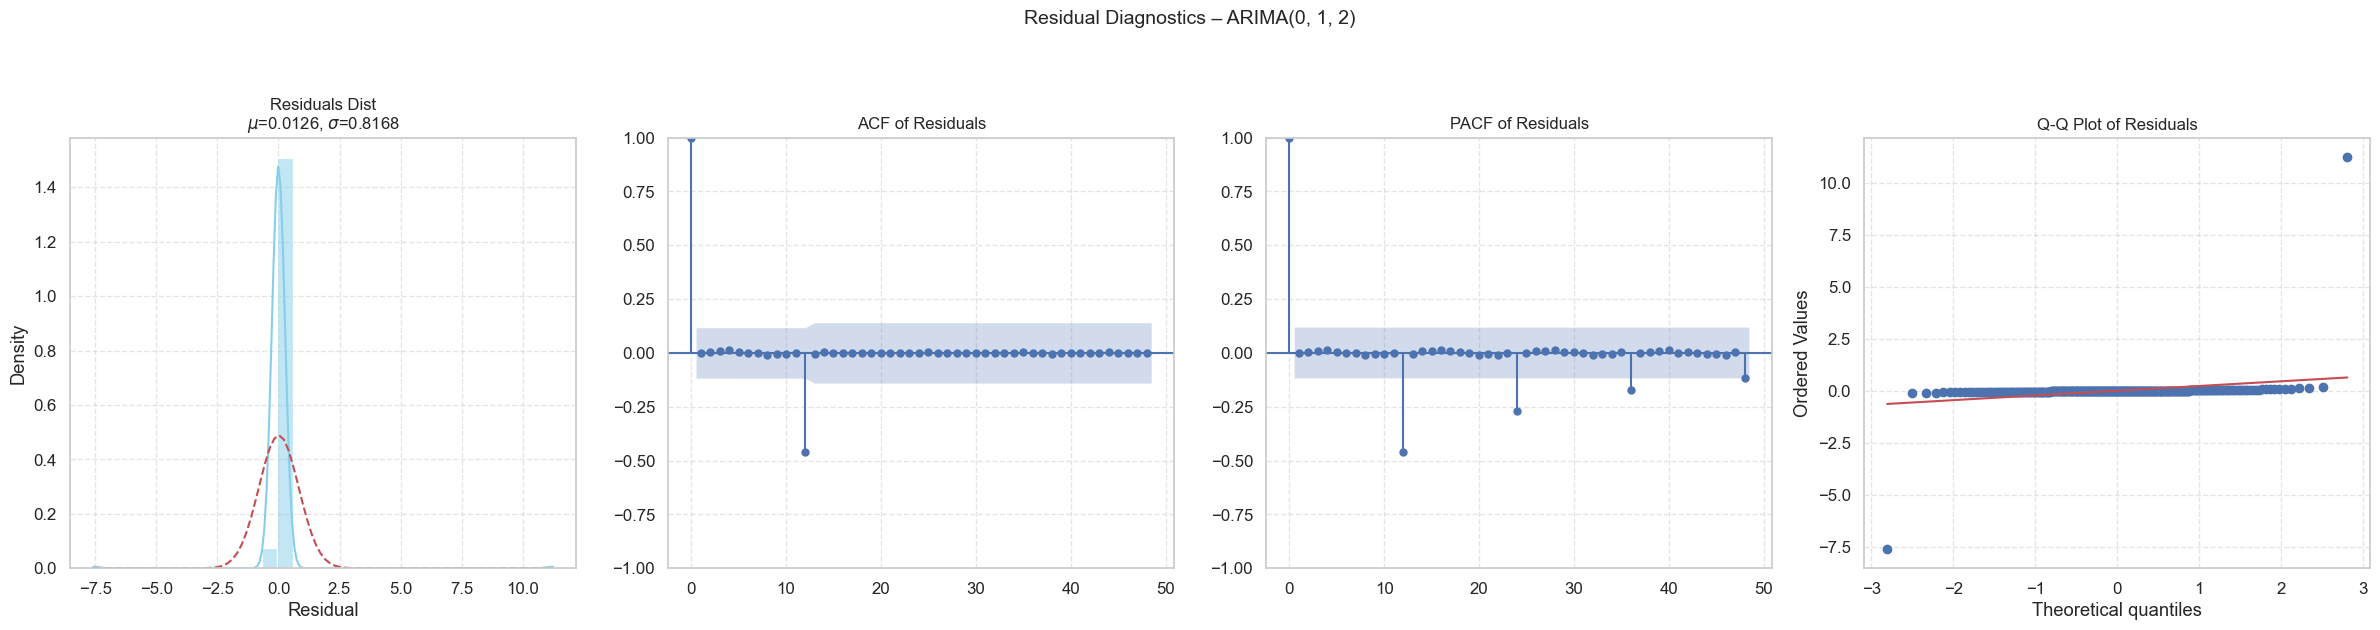

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(style='whitegrid', font_scale=1.1)

resid = best_model.resid
mu, sigma = stats.norm.fit(resid)

fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # 1 row, 4 columns

# --- Histogram + KDE + Fitted Normal Curve ---
sns.histplot(resid, kde=True, stat="density", bins=30, color='skyblue', ax=axes[0])
x = np.linspace(resid.min(), resid.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r--')
axes[0].set_title(f'Residuals Dist\n$\mu$={mu:.4f}, $\sigma$={sigma:.4f}', fontsize=12)
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- ACF Plot ---
plot_acf(resid, lags=48, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of Residuals', fontsize=12)
axes[1].set_ylim(-1, 1)
axes[1].grid(True, linestyle='--', alpha=0.5)

# --- PACF Plot ---
plot_pacf(resid, lags=48, ax=axes[2], alpha=0.05, method='ywm')
axes[2].set_title('PACF of Residuals', fontsize=12)
axes[2].set_ylim(-1, 1)
axes[2].grid(True, linestyle='--', alpha=0.5)

# --- Q-Q Plot ---
stats.probplot(resid, dist="norm", plot=axes[3])
axes[3].set_title('Q-Q Plot of Residuals', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.5)

# --- Main Title and Layout ---
plt.suptitle(f'Residual Diagnostics – ARIMA{best_model.model.order}', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Residuals is not compulsory to be normal , its needed to be normal at that time when we are doing tests for any hypothesis or finding confidence intervals

In [65]:
lb_test = acorr_ljungbox(resid, lags=range(10, 70), return_df=True)
print(lb_test)

      lb_stat     lb_pvalue
10   0.097186  1.000000e+00
11   0.099303  1.000000e+00
12  62.146958  9.140910e-09
13  62.150434  2.160333e-08
14  62.153930  4.899306e-08
15  62.153931  1.071109e-07
16  62.154710  2.259697e-07
17  62.154726  4.614084e-07
18  62.155483  9.132600e-07
19  62.155643  1.756307e-06
20  62.156989  3.284980e-06
21  62.157938  5.988048e-06
22  62.159004  1.065011e-05
23  62.159522  1.850806e-05
24  62.160243  3.145347e-05
25  62.162117  5.230965e-05
26  62.162437  8.528712e-05
27  62.162471  1.363823e-04
28  62.162563  2.140424e-04
29  62.163141  3.298928e-04
30  62.163728  4.997320e-04
31  62.164610  7.444492e-04
32  62.165531  1.091338e-03
33  62.165535  1.575664e-03
34  62.165738  2.241016e-03
35  62.169544  3.138733e-03
36  62.170508  4.338194e-03
37  62.170541  5.916743e-03
38  62.174504  7.957422e-03
39  62.174655  1.057630e-02
40  62.174958  1.388462e-02
41  62.175948  1.800897e-02
42  62.176450  2.309210e-02
43  62.176693  2.928089e-02
44  62.185012  3.667

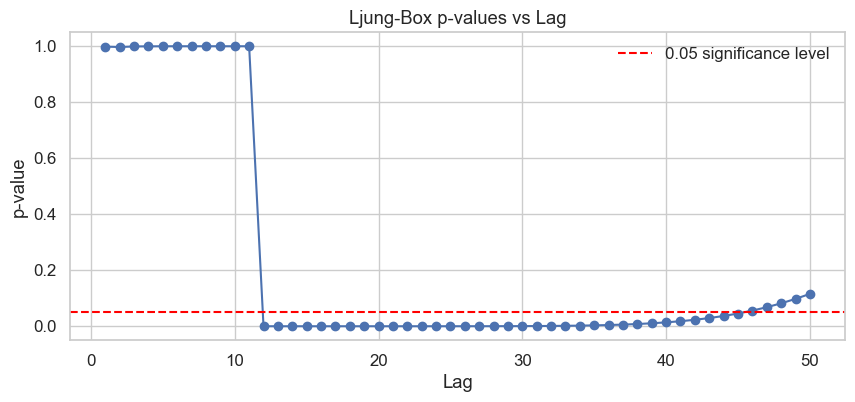

In [66]:
import matplotlib.pyplot as plt

# Run Ljung-Box test up to 50 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(best_model.resid, lags=50, return_df=True)

# Plot p-values
plt.figure(figsize=(10, 4))
plt.plot(lb_result.index, lb_result['lb_pvalue'], marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('Ljung-Box p-values vs Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()


So we see as the number of lags increased , our residuals shows white noise which proved the assumption of arima and sarima models

In [68]:
from statsmodels.stats.diagnostic import het_arch

# Assuming you have residuals from SARIMA model
arch_test = het_arch(best_model.resid)

print("LM Statistic:", arch_test[0])
print("p-value:", arch_test[1])


LM Statistic: 0.04000139805377545
p-value: 0.9999999999737694


Why It Matters
If your residuals are heteroscedastic, traditional models like ARIMA or SARIMA may produce inefficient forecasts.

You may need models like GARCH to handle the volatility properly.

📊 What Is the ARCH Test?
The ARCH test checks whether:

The variance of the residuals at time t depends on past squared residuals.

In short: If today's variance is influenced by yesterday's errors, you're seeing conditional heteroscedasticity.

🔬 How It Works (Conceptually)
Fit your time series model (like SARIMA) and get the residuals.

Square the residuals.

Regress the squared residuals on lagged squared residuals.

Test if the coefficients are statistically significant.

✅ Interpretation
Null Hypothesis (H₀): No ARCH effect (i.e., residuals are homoscedastic).

Alternative Hypothesis (H₁): ARCH effects present (i.e., heteroscedastic residuals).

If the p-value < 0.05, reject H₀ ⇒ residuals are heteroscedastic.

So we see our p values is highly larger than 0.05 so we conclude our residuals is homoscedastic in nature and the asumption holds



<Figure size 1200x600 with 0 Axes>

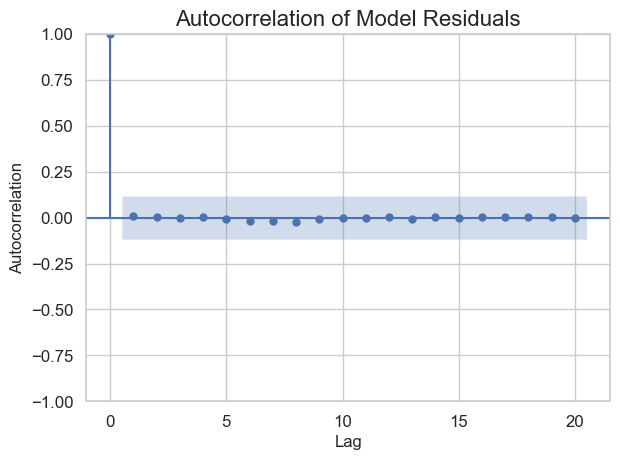

In [69]:
plt.figure(figsize=(12, 6))

plot_acf(best_model.resid[1:].squeeze(), lags=20, alpha=0.05)

plt.title('Autocorrelation of Model Residuals', fontsize=16)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## All autocorrelations (for lags 1 to 20) are:

Very close to zero

Inside the blue confidence bands (typically 95% CI)

🔍 Interpretation:
✅ No significant autocorrelation in residuals → residuals are random

✅ Residuals resemble white noise, which is what we want after fitting an ARIMA/SARIMA model

In [70]:
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values)  

In [45]:
from sklearn.metrics import mean_absolute_error, r2_score

preds_best=np.exp(best_model.predict(start=test_start_date,end='2025-04-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,preds_best),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,preds_best),2)))
print("RMSE:{}".format(np.round(root_mean_squared_error(test_data,preds_best),2)))
print("R² Score:{}".format(np.round(r2_score(test_data, preds_best), 4)))


NameError: name 'mean_abs_pct_error' is not defined

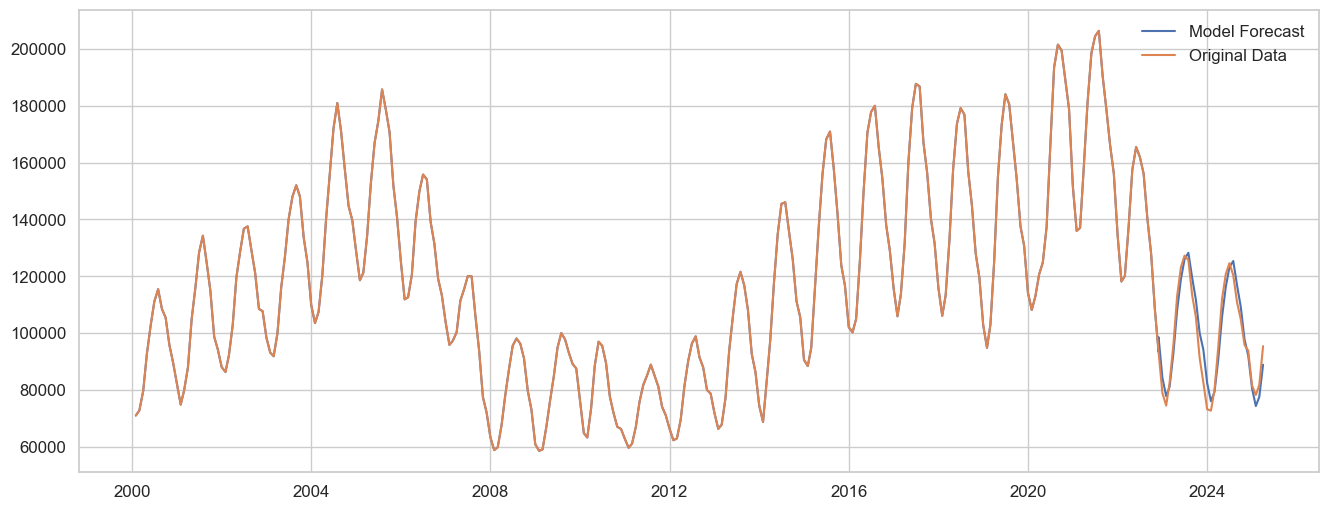

In [75]:
model_data = training_data.values[1:].reshape(275) - best_model.resid[1:]
model_data = pd.concat((model_data,preds_best))
plt.figure(figsize=(16,6));
plt.plot(model_data);
plt.plot(original_data[1:]);
plt.legend(['Model Forecast','Original Data']);

2023-01-01    11.254040
2023-02-01    11.144212
2023-03-01    11.186606
2023-04-01    11.323135
2023-05-01    11.472090
2023-06-01    11.569235
2023-07-01    11.627165
2023-08-01    11.644403
2023-09-01    11.573210
2023-10-01    11.506893
2023-11-01    11.395443
2023-12-01    11.328798
Freq: MS, Name: predicted_mean, dtype: float64


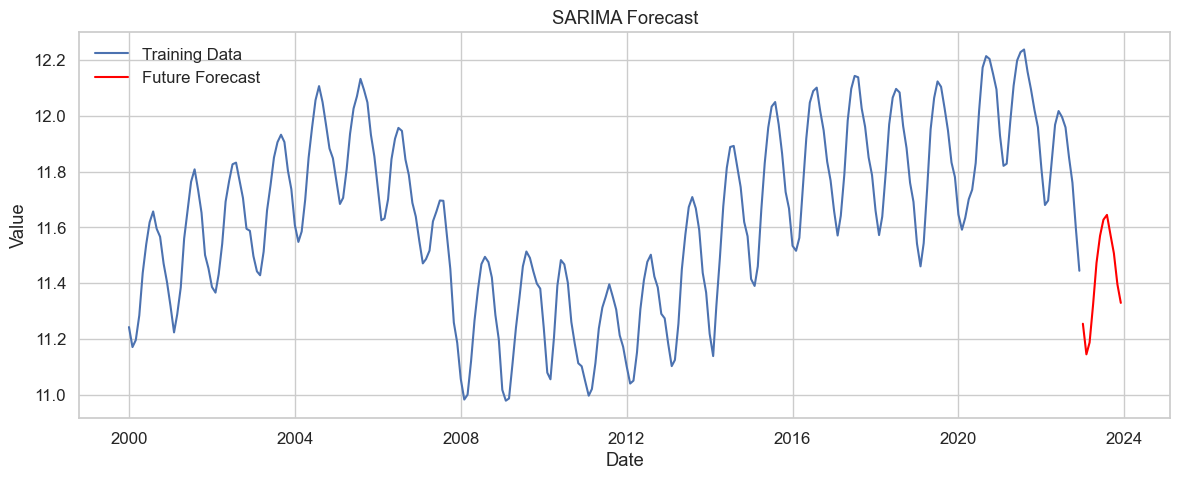

In [76]:
future_forecast = best_model.forecast(steps=12)  # Predict next 12 months
print(future_forecast)

import matplotlib.pyplot as plt

# Combine original and forecast
plt.figure(figsize=(12, 5))
plt.plot(log_transformed_data, label="Training Data")
plt.plot(future_forecast.index, future_forecast, label="Future Forecast", color="red")
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
tests_score = []
trains_score = []
models_order = []
models_aic = []

for model in models:
    if model.aic < -1000:
        model_order = "ar:" + str(model.model_orders['ar']) + " ma:" + str(model.model_orders['ma']) + " s_ar:" + str(int(model.model_orders['seasonal_ar']/12)) + " s_ma:" + str(int(model.model_orders['seasonal_ma']/12))
        models_order.append(model_order)
        models_aic.append(model.aic)
        train_forecasts = training_data.values[1:].reshape(275) - model.resid[1:]
        train_mae = mean_absolute_error(training_data[1:], train_forecasts)
        trains_score.append(np.round(train_mae,3))
        preds=np.exp(model.predict(start=test_start_date, end='2025-04-01', dynamic=True, typ='levels'))    

        test_mape = mean_abs_pct_error(test_data,preds)
        tests_score.append(np.round(test_mape,3))
        
model_properties = {'aic':models_aic, 'model_order':models_order, 'train_score': trains_score, 'test_score':tests_score}    

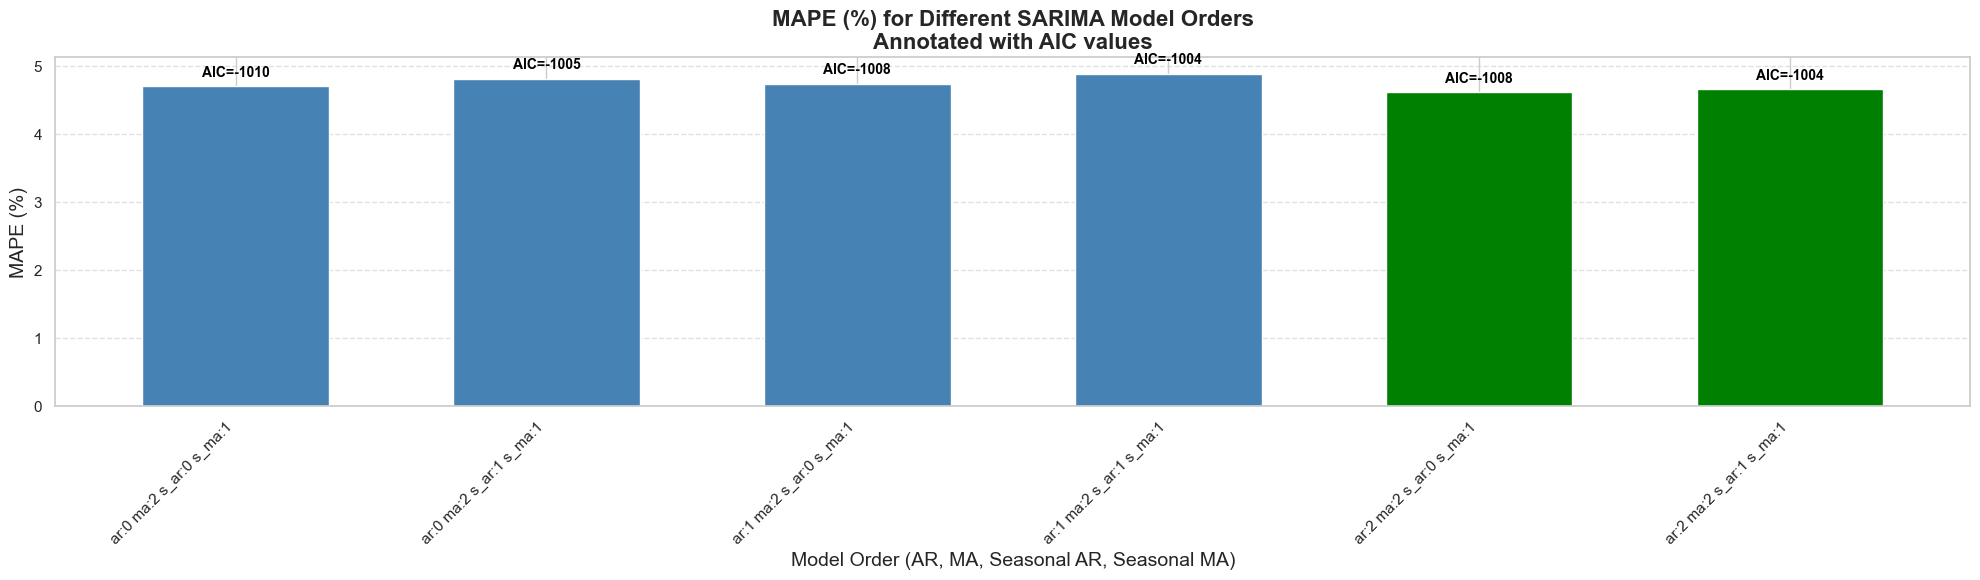

In [78]:
colors = ['green' if x < 4.71 else 'steelblue' for x in model_properties['test_score']]

plt.figure(figsize=(20, 6))
bars = plt.bar(model_properties['model_order'], model_properties['test_score'], color=colors, width=0.6)


plt.xlabel('Model Order (AR, MA, Seasonal AR, Seasonal MA)', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=14)
plt.title('MAPE (%) for Different SARIMA Model Orders\nAnnotated with AIC values', fontsize=16, fontweight='bold')

for i, (bar, aic_val) in enumerate(zip(bars, model_properties['aic'])):
    height = bar.get_height()
    plt.annotate(f'AIC={int(aic_val)}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', va='bottom',
                 fontsize=10, color='black', fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [79]:
agile_model = SARIMAX(endog=log_transformed_data,order=(2,1,2), seasonal_order=(1,1,2,12), enforce_invertibility=False).fit()
agile_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       SPCS20RPSNSA   No. Observations:                  276
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 545.161
Date:                            Thu, 07 Aug 2025   AIC                          -1074.322
Time:                                    11:32:14   BIC                          -1045.745
Sample:                                01-01-2000   HQIC                         -1062.838
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2130      0.138      1.543      0.123      -0.058       0.484
ar.L2         -0.2186      0.110     -1.987      0.047      -0.434      -0.003
ma.L1          0.4455      0.130      3.437      0.001       0.191       0.700
ma.L2          0.5641      0.053     10.613      0.000       0.460       0.668
ar.S.L12      -0.3934      0.347     -1.135      0.256      -1.073       0.286
ma.S.L12      -0.3592      0.345     -1.042      0.297      -1.035       0.316
ma.S.L24      -0.4873      0.277     -1.762      0.078      -1.029       0.055
sigma2         0.0009   5.89e-05     14.653      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               246.56
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             1.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

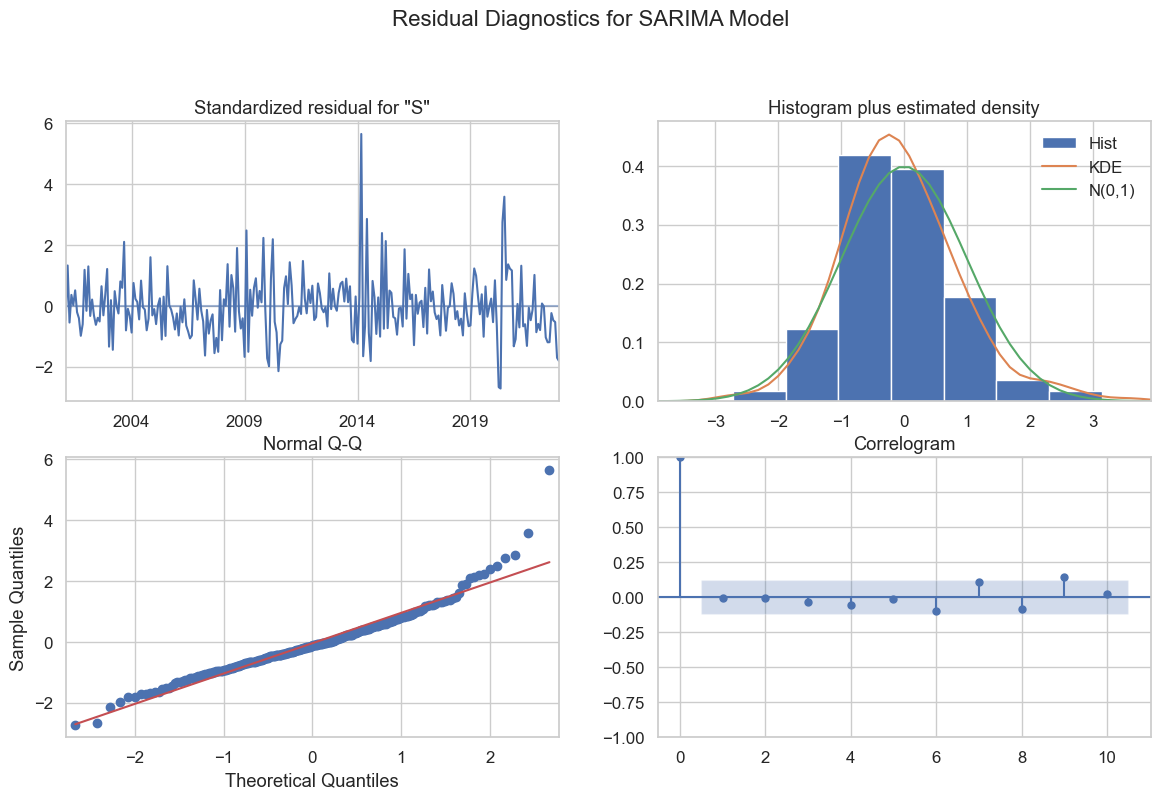

In [52]:
agile_model.plot_diagnostics(figsize=(14, 8));
plt.suptitle('Residual Diagnostics for SARIMA Model', fontsize=16, y=1.02);

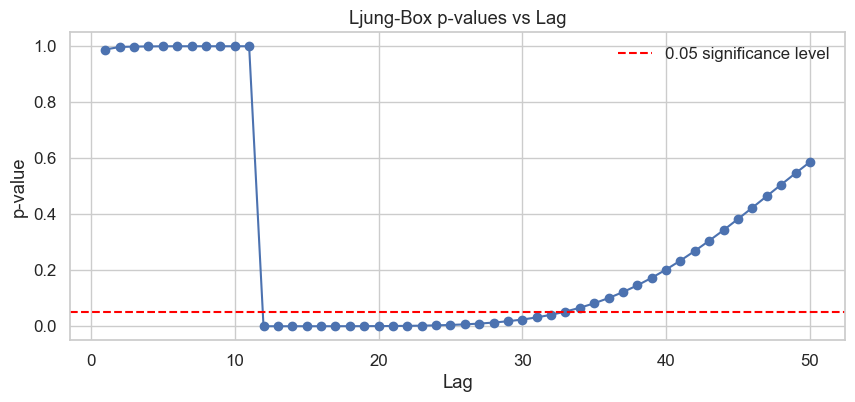

In [56]:
import matplotlib.pyplot as plt

# Run Ljung-Box test up to 50 lags
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(agile_model.resid, lags=50, return_df=True)

# Plot p-values
plt.figure(figsize=(10, 4))
plt.plot(lb_result.index, lb_result['lb_pvalue'], marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('Ljung-Box p-values vs Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\sayan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


C:\Users\sayan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1010 - learning_rate: 0.0010
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220 - learning_rate: 0.0010
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - learning_rate: 0.001

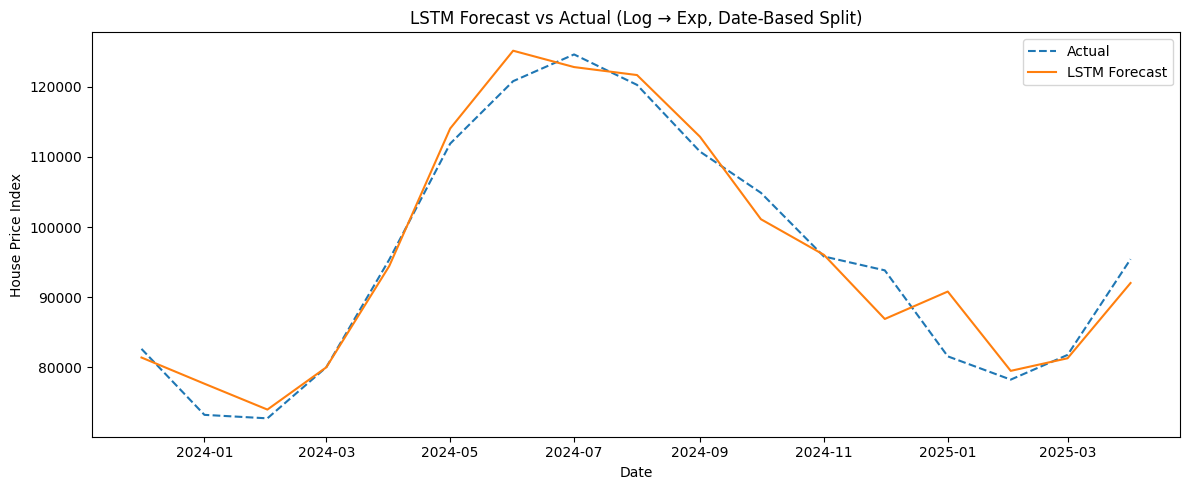

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Load and log-transform ---
df = pd.read_csv("SPCS20RPSNSA.csv", parse_dates=['observation_date'], index_col='observation_date')
original_data = df.copy()
original_data['SPCS20RPSNSA'] = np.log(original_data['SPCS20RPSNSA'].astype('float32'))  # log transform

# --- Date-based split ---
test_start_date = '2022-12-01'
training_data = original_data[:test_start_date]
test_data = original_data[test_start_date:]

training_series = training_data['SPCS20RPSNSA']
test_series = test_data['SPCS20RPSNSA']

# --- Scaling ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_series.values.reshape(-1, 1))

# --- TimeSeriesGenerator ---
lookback = 12
train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=lookback, batch_size=1)
test_gen = TimeseriesGenerator(test_scaled, test_scaled, length=lookback, batch_size=1)

# --- LSTM Model ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(lookback, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# --- Callbacks ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# --- Train ---
model.fit(train_gen, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=1)

# --- Predict ---
pred_scaled = model.predict(test_gen)
y_test_scaled = test_scaled[lookback:]
y_pred_scaled = pred_scaled

# --- Inverse transform ---
y_test_log = scaler.inverse_transform(y_test_scaled)
y_pred_log = scaler.inverse_transform(y_pred_scaled)

y_test = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 LSTM Evaluation (Date-Based Split, Real Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot ---
dates = test_series.index[lookback:]  # align with predictions
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test, label='Actual', linestyle='--')
plt.plot(dates, y_pred, label='LSTM Forecast', linestyle='-')
plt.title("LSTM Forecast vs Actual (Log → Exp, Date-Based Split)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()



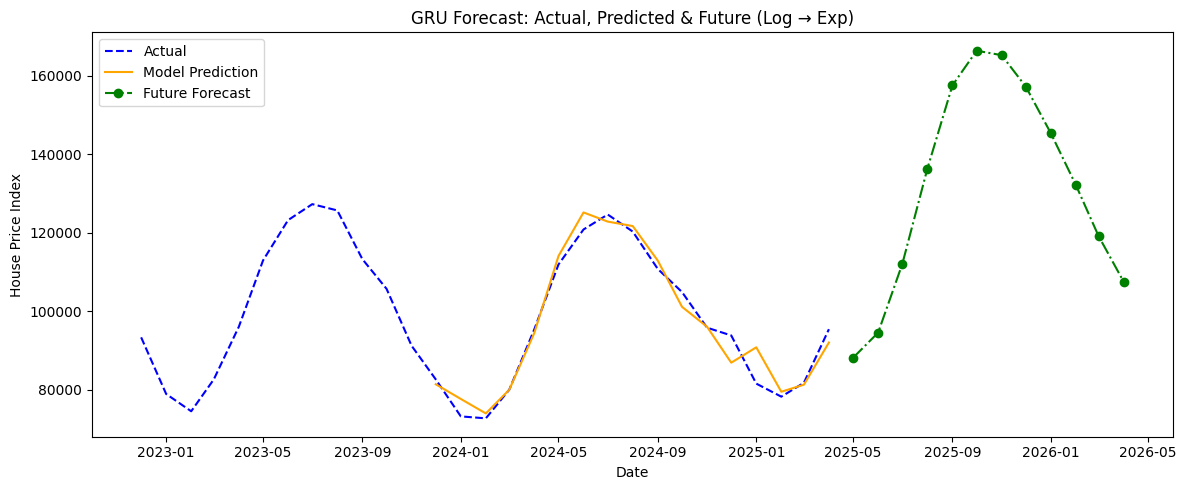

In [5]:
# --- Forecast Future Steps ---
n_future = 12  # months to forecast
forecast_input = train_scaled[-lookback:].reshape(1, lookback, 1)  # last window
forecast_scaled = []

for _ in range(n_future):
    next_pred = model.predict(forecast_input, verbose=0)[0]
    forecast_scaled.append(next_pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[next_pred]], axis=1)

# --- Inverse transform and exponentiate forecast ---
forecast_log = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))
forecast = np.exp(forecast_log)

# --- Fix: ensure continuous forecast dates ---
last_date = test_series.index[-1]
start_of_next_month = last_date + pd.offsets.MonthBegin(1)
forecast_dates = pd.date_range(start=start_of_next_month, periods=n_future, freq='MS')

# --- Fix: exponentiate actual test series ---
actual_values = np.exp(test_series.values)
dates = test_series.index[lookback:]  # prediction-aligned dates

# --- Plot everything cleanly ---
plt.figure(figsize=(12, 5))

# Actual values
plt.plot(test_series.index, actual_values, label='Actual', linestyle='--', color='blue')

# Model predictions
plt.plot(dates, y_pred, label='Model Prediction', linestyle='-', color='orange')

# Forecast
plt.plot(forecast_dates, forecast, label='Future Forecast', linestyle='-.', marker='o', color='green')

plt.title("GRU Forecast: Actual, Predicted & Future (Log → Exp)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\sayan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1180 - learning_rate: 0.0010
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170 - learning_rate: 0.0010
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0107 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - learning_rate: 0.001

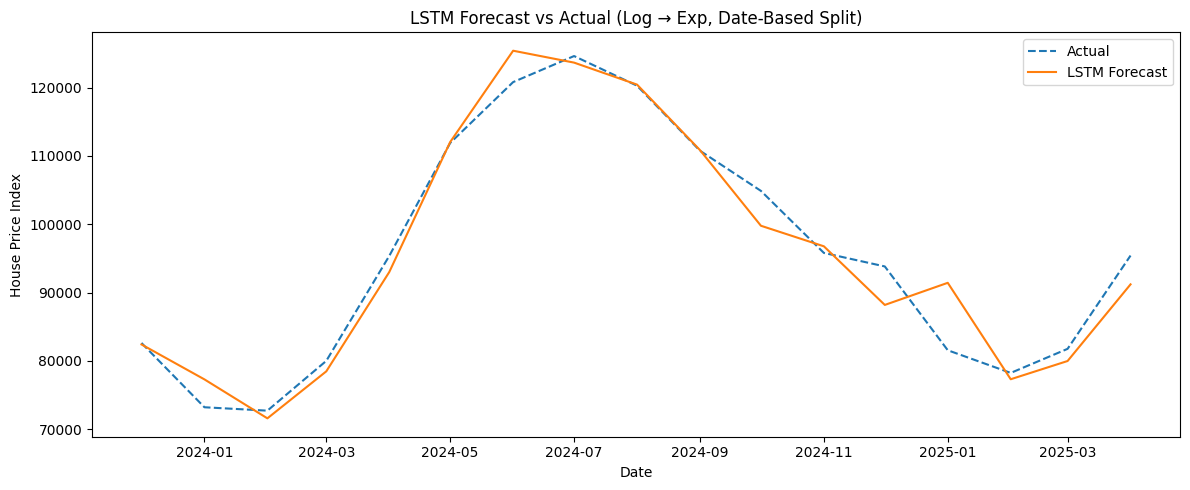

In [6]:
# --- LSTM Model ---
from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(64, activation='relu', input_shape=(lookback, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# --- Callbacks ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# --- Train ---
model.fit(train_gen, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=1)

# --- Predict ---
pred_scaled = model.predict(test_gen)
y_test_scaled = test_scaled[lookback:]
y_pred_scaled = pred_scaled

# --- Inverse transform ---
y_test_log = scaler.inverse_transform(y_test_scaled)
y_pred_log = scaler.inverse_transform(y_pred_scaled)

y_test = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 LSTM Evaluation (Date-Based Split, Real Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot ---
dates = test_series.index[lookback:]  # align with predictions
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test, label='Actual', linestyle='--')
plt.plot(dates, y_pred, label='LSTM Forecast', linestyle='-')
plt.title("LSTM Forecast vs Actual (Log → Exp, Date-Based Split)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\sayan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1131 - learning_rate: 0.0010
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0258 - learning_rate: 0.0010
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0099 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 10/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 11/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0022 - learning

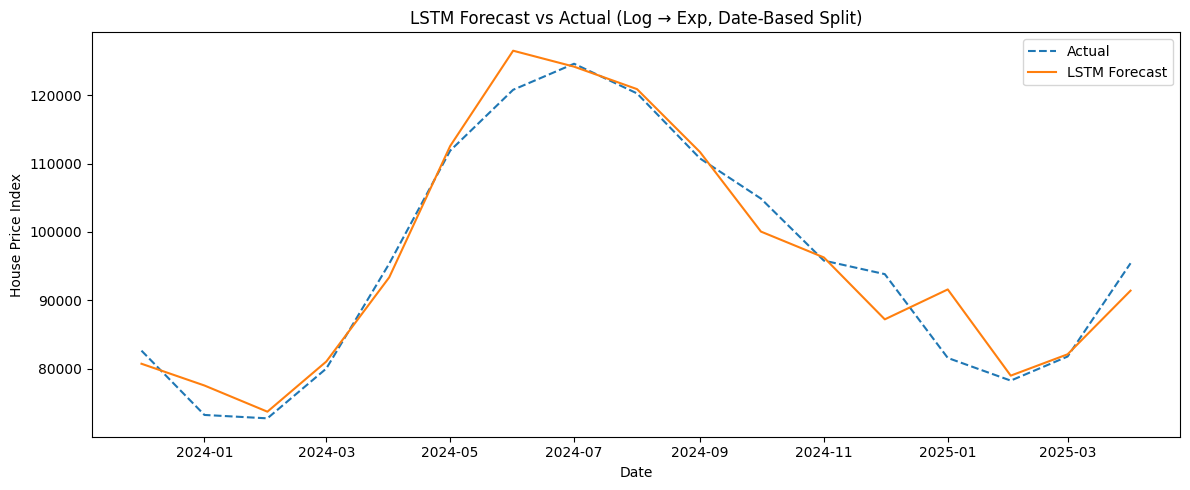

In [7]:
# --- LSTM Model ---
from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
    GRU(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse')

# --- Callbacks ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# --- Train ---
model.fit(train_gen, epochs=100, callbacks=[early_stop, lr_scheduler], verbose=1)

# --- Predict ---
pred_scaled = model.predict(test_gen)
y_test_scaled = test_scaled[lookback:]
y_pred_scaled = pred_scaled

# --- Inverse transform ---
y_test_log = scaler.inverse_transform(y_test_scaled)
y_pred_log = scaler.inverse_transform(y_pred_scaled)

y_test = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 LSTM Evaluation (Date-Based Split, Real Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot ---
dates = test_series.index[lookback:]  # align with predictions
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test, label='Actual', linestyle='--')
plt.plot(dates, y_pred, label='LSTM Forecast', linestyle='-')
plt.title("LSTM Forecast vs Actual (Log → Exp, Date-Based Split)")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.legend()
plt.tight_layout()
plt.show()

1. Lookback (Sequence Length)

lookback = 12

This means: your LSTM will look at the previous 12 time steps (months, in your case) to predict the next value.

It's like saying: "Based on the past 12 months of prices, predict the next month's price."

test_start_date = '2022-12-01'

training_data = original_data[:test_start_date]

test_data = original_data[test_start_date:]

Training data: from the start of your dataset up to (but not including) Dec 2022

Testing data: from Dec 2022 onward

The target column: 'SPCS20RPSNSA', which has been log-transformed

Suppose your data is like this (after scaling):
[t0, t1, t2, ..., t13]

Then:

First sample: X = [t0..t11], y = t12

Second sample: X = [t1..t12], y = t13

... and so on

So:

Training samples: len(training_data) - lookback

Test samples: len(test_data) - lookback

In [39]:
## sarima is working slightly better than lstm , the reason lies here the data is small so DL model underperforms though it worked surprisingly well considering the dataset size

# Implementation of Facebook - Prophet

#   Prepare the data for Prophet
###  Prophet requires:

#### a column named "ds" for dates

#### column named "y" for the target 

In [51]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Create a Prophet-compatible DataFrame
df_prophet = original_data.copy()
df_prophet = np.log(df_prophet)
df_prophet = df_prophet.reset_index().rename(columns={"observation_date": "ds", "SPCS20RPSNSA": "y"})

# Split into train/test
split_date = "2022-12-01"
train_df = df_prophet[df_prophet["ds"] <= split_date]
test_df = df_prophet[df_prophet["ds"] > split_date]


In [52]:
# Initialize and fit the model
prophet = Prophet()
prophet.fit(train_df)

# Create future dataframe (same length as test set)
future = prophet.make_future_dataframe(periods=len(test_df), freq='MS')

# Predict
forecast = prophet.predict(future)

# Extract predictions for test period
predicted_log = forecast.set_index("ds").loc[test_df["ds"], "yhat"]
actual_log = test_df.set_index("ds")["y"]


09:34:16 - cmdstanpy - INFO - Chain [1] start processing
09:34:16 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# Inverse transform (from log scale back to original scale)
actual_orig = np.exp(actual_log)
predicted_orig = np.exp(predicted_log)

# Evaluation on original scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(actual_orig, predicted_orig))
mae = mean_absolute_error(actual_orig, predicted_orig)
r2 = r2_score(actual_orig, predicted_orig)

print(f"\n Prophet Forecast Evaluation (Original Scale):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")




 Prophet Forecast Evaluation (Original Scale):
RMSE: 0.41
MAE: 0.41
R² Score: -4.0862


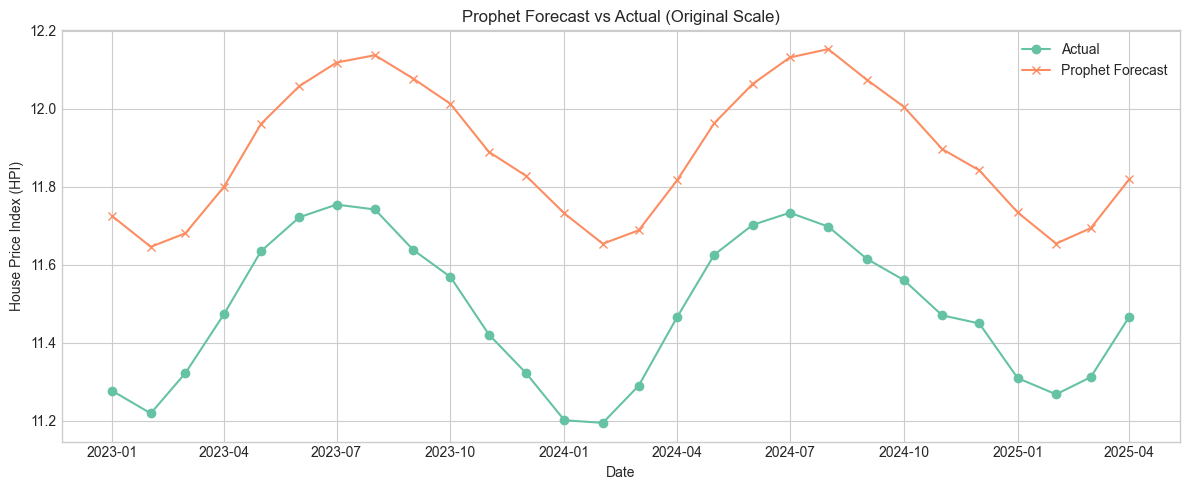

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(actual_orig.index, actual_orig, label='Actual', marker='o')
plt.plot(predicted_orig.index, predicted_orig, label='Prophet Forecast', marker='x')
plt.title("Prophet Forecast vs Actual (Original Scale)")
plt.xlabel("Date")
plt.ylabel("House Price Index (HPI)")
plt.legend()
plt.tight_layout()
plt.show()
